In [1]:
%matplotlib inline
%timeit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import pickle
import datetime
import re
import pyActigraphy

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data as weardata
from wearables.scripts import train as weartrain
from wearables.scripts import eval_ as weareval
from wearables.scripts import model as wearmodels
from wearables.scripts import DTW as weardtw

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.spatial.distance import pdist, squareform
import fastdtw
import umap

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1
plt.rcParams['savefig.dpi'] = 600
sns.set_style("ticks")

In [3]:
# load data
mfp = '/home/ngrav/scratch/wearables_model_zoo'
bst_modelpkl = os.path.join(mfp, '281-itv71_InceptionTime_GA4.pkl')
bst_trainer = os.path.join(mfp, 'trainer_itv71_InceptionTime_GA4.pkl')

split = 'train'

X, md_model, trainer = weardtw.data_from_trainer(bst_trainer, split=split)

# call eval to get output, modify for return_hidden = True option
evaluation = weareval.eval_trained(trainer, split=split,
                                   modelpkl=bst_modelpkl,
                                   two_outputs=True)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/modules/conv.py:294: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/Convolution.cpp:660.)
  return F.conv1d(input, weight, bias, self.stride,
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [4]:
import functools
import operator
import torch
from torch.autograd import grad
import numpy as np
from tqdm import *

def gather_nd(params, indices):
    """
    Args:
        params: Tensor to index
        indices: k-dimension tensor of integers. 
    Returns:
        output: 1-dimensional tensor of elements of ``params``, where
            output[i] = params[i][indices[i]]
            
            params   indices   output
            1 2       1 1       4
            3 4       2 0 ----> 5
            5 6       0 0       1
    """
    max_value = functools.reduce(operator.mul, list(params.size())) - 1
    indices = indices.t().long()
    ndim = indices.size(0)
    idx = torch.zeros_like(indices[0]).long()
    m = 1

    for i in range(ndim)[::-1]:
        idx += indices[i]*m
        m *= params.size(i)

    idx[idx < 0] = 0
    idx[idx > max_value] = 0
    return torch.take(params, idx)

class PathExplainerTorch(object):
    def __init__(self, model):
        self.model = model
        return
    
    def _get_ref_tensor(self,baseline,batch_size,num_samples):
        number_to_draw = num_samples * batch_size
        replace = baseline.shape[0] < number_to_draw
        sample_indices = np.random.choice(baseline.shape[0],
                                          size=number_to_draw,
                                          replace=replace)
        ref_tensor = baseline[sample_indices,:]
        
        return ref_tensor

    def _get_samples_input(self, input_tensor, baseline, 
                           num_samples, use_expectation):
        '''
        calculate interpolation points
        Args:
            input_tensor: Tensor of shape (batch, ...), where ... indicates
                          the input dimensions. 
            reference_tensor: A tensor of shape (batch, k, ...) where ... 
                indicates dimensions, and k represents the number of background 
                reference samples to draw per input in the batch.
        Returns: 
            samples_input: A tensor of shape (batch, k, ...) with the 
                interpolated points between input and ref.
            samples_delta: A tensor of shape (batch, 1, ...) with the
                difference between input and reference for each sample
        '''
        input_dims = list(input_tensor.size())[1:]
        num_input_dims = len(input_dims)
        batch_size = input_tensor.size()[0]
        
        if use_expectation:
            reference_tensor = self._get_ref_tensor(baseline,batch_size,num_samples)
            shape = reference_tensor.shape
            reference_tensor = reference_tensor.view(
                    batch_size, 
                    num_samples, 
                    *(shape[1:]))
            
            # Grab a [batch_size, k]-sized interpolation sample
            t_tensor = torch.FloatTensor(batch_size, num_samples).uniform_(0,1).to(reference_tensor.device)
            shape = [batch_size, num_samples] + [1] * num_input_dims
            interp_coef = t_tensor.view(*shape)

            # Evaluate the end points
            end_point_ref = (1.0 - interp_coef) * reference_tensor

            input_expand_mult = input_tensor.unsqueeze(1)
            end_point_input = interp_coef * input_expand_mult

            # Affine Combine
            samples_input = end_point_input + end_point_ref
            
        else:
            batch_size = input_tensor.size()[0]
            input_expand = input_tensor.unsqueeze(1)
            reps = np.ones(len(baseline.shape)).astype(int)
            reps[0] = batch_size
            reference_tensor = baseline.repeat(list(reps)).unsqueeze(1)
#             reference_tensor = torch.as_tensor(sampled_baseline).unsqueeze(1).to(baseline.device)
            scaled_inputs = [reference_tensor + (float(i)/(num_samples-1))*(input_expand - reference_tensor) \
                             for i in range(0,num_samples)]
            samples_input = torch.cat(scaled_inputs,dim=1)
        
        samples_delta = self._get_samples_delta(input_tensor, reference_tensor)
        samples_delta = samples_delta.to(samples_input.device)
        
        return samples_input, samples_delta
    
    def _get_samples_delta(self, input_tensor, reference_tensor):
        input_expand_mult = input_tensor.unsqueeze(1)
        sd = input_expand_mult - reference_tensor
        return sd
    
    def _get_grads(self, samples_input, output_indices=None):

        grad_tensor = torch.zeros(samples_input.shape).float().to(samples_input.device)
        
        k_ = samples_input.shape[1]

        for i in range(k_):
            particular_slice = samples_input[:,i]
            batch_output = self.model(particular_slice)
            # should check that users pass in sparse labels
            # Only look at the user-specified label
            if batch_output.size(1) > 1:
                sample_indices = torch.arange(0,batch_output.size(0)).to(samples_input.device)
                indices_tensor = torch.cat([
                        sample_indices.unsqueeze(1), 
                        output_indices.unsqueeze(1)], dim=1)
                batch_output = gather_nd(batch_output, indices_tensor)

            model_grads = grad(
                    outputs=batch_output,
                    inputs=particular_slice,
                    grad_outputs=torch.ones_like(batch_output).to(samples_input.device),
                    create_graph=True)
            grad_tensor[:,i,:] = model_grads[0]
        return grad_tensor
           
    def attributions(self, input_tensor, baseline,
                     num_samples = 50, use_expectation=True, 
                     output_indices=None):
        """
        Calculate either Expected or Integrated Gradients approximation of 
        Aumann-Shapley values for the sample ``input_tensor``.
        Args:
            model (torch.nn.Module): Pytorch neural network model for which the
                output should be explained.
            input_tensor (torch.Tensor): Pytorch tensor representing the input
                to be explained.
            baseline (torch.Tensor): Pytorch tensor representing the baseline.
                If use_expectation is true, then baseline should be shape
                (num_refs, ...) where ... indicates the dimensionality
                of the input. Otherwise, baseline should be shape (1, ...).
            output_indices (optional, default=None): For multi-class prediction
        """
        equal_dims = baseline.shape[1:] == input_tensor.shape[1:]
        almost_equal_dims = baseline.shape == input_tensor.shape[1:]
        
        dev = input_tensor.device
        baseline = baseline.to(dev)
        
        input_tensor.requires_grad_ = True
        
        if use_expectation and not equal_dims:
            raise ValueError('baseline should be shape (num_refs, ...) \
                              where ... indicates the dimensionality   \
                              of the input')
            
        if not use_expectation and baseline.shape[0] != 1:
            if almost_equal_dims:
                baseline = baseline.unsqueeze(0)
            else:
                raise ValueError('baseline should be shape (...)           \
                                  where ... indicates the dimensionality   \
                                  of the input')
        
        samples_input, samples_delta = self._get_samples_input(input_tensor, baseline,
                                                               num_samples, use_expectation)
        grad_tensor = self._get_grads(samples_input, output_indices)
        mult_grads = samples_delta * grad_tensor
        attributions = mult_grads.mean(1)
        
        return attributions
    
    def interactions(self, input_tensor, baseline,
                     num_samples=50, use_expectation=True,
                     output_indices=None, interaction_index=None,
                     verbose=True):
        """
            input_tensor (torch.Tensor): Pytorch tensor representing the input
                to be explained.
            baseline (torch.Tensor): Pytorch tensor representing the baseline.
                If use_expectation is true, then baseline should be shape
                (num_refs, ...) where ... indicates the dimensionality
                of the input. Otherwise, baseline should be shape (1, ...)
            num_samples: The number of samples to use when computing the
                         expectation or integral.
            use_expectation: If True, this samples baselines and interpolation
                             constants uniformly at random (expected gradients).
                             If False, then this assumes num_refs=1 in which
                             case it uses the same baseline for all inputs,
                             or num_refs=batch_size, in which case it uses
                             baseline[i] for inputs[i] and takes 100 linearly spaced
                             points between baseline and input (integrated gradients).
            output_indices:  If this is None, then this function returns the
                             attributions for each output class. This is rarely
                             what you want for classification tasks. Pass an
                             integer tensor of shape [batch_size] to
                             index the output output_indices[i] for
                             the input inputs[i].
            interaction_index: Either None or an index into the input. If the latter,
                               will compute the interactions with respect to that
                               feature. This parameter should index into a batch
                               of inputs as inputs[(slice(None) + interaction_index)].
                               For example, if you had images of shape (32, 32, 3)
                               and you wanted interactions with respect
                               to pixel (i, j, c), you should pass
                               interaction_index=[i, j, c].
        
        """
        
        if len(input_tensor.shape) != 2:
            raise ValueError('PyTorch Explainer only supports ' + \
                             'interaction for 2D input tensors!')
        
        equal_dims = baseline.shape[1:] == input_tensor.shape[1:]
        almost_equal_dims = baseline.shape == input_tensor.shape[1:]
        
        if use_expectation and not equal_dims:
            raise ValueError('baseline should be shape (num_refs, ...) \
                              where ... indicates the dimensionality   \
                              of the input')
            
        if not use_expectation and baseline.shape[0] != 1:
            if almost_equal_dims:
                baseline = baseline.unsqueeze(0)
            else:
                raise ValueError('baseline should be shape (...)           \
                                  where ... indicates the dimensionality   \
                                  of the input')
        
        inner_loop_nsamples = int(round(np.sqrt(num_samples)))
        
        samples_input, samples_delta = self._get_samples_input(input_tensor, baseline,
                                                               inner_loop_nsamples, use_expectation)
        
        if interaction_index is not None:
            interaction_mult_tensor = torch.zeros([input_tensor.size(0), samples_input.size(1), input_tensor.size(1)])
        else:
            interaction_mult_tensor = torch.zeros([input_tensor.size(0), samples_input.size(1), 
                                                   input_tensor.size(1), input_tensor.size(1)])
            
        ig_tensor = torch.zeros(samples_input.shape).float()
        
        loop_num = inner_loop_nsamples
        
        if verbose:
            iterable = tqdm(range(loop_num))
        else:
            iterable = range(loop_num)
        
        for i in iterable:
            
            particular_slice = samples_input[:,i]
            ig_tensor[:,i,:] = self.attributions(particular_slice, baseline,
                                                 num_samples=inner_loop_nsamples, use_expectation=use_expectation,
                                                 output_indices=output_indices)
            
            if interaction_index is not None:
                second_grads = grad(
                        outputs=ig_tensor[:,i,interaction_index],
                        inputs=particular_slice,
                        grad_outputs=torch.ones_like(ig_tensor[:,i,interaction_index]),
                        create_graph=True)[0].detach()
                interaction_mult_tensor[:,i,:] = second_grads

            else:
                for feature in range(input_tensor.size(1)):
                    second_grads = grad(
                        outputs=ig_tensor[:,i,feature],
                        inputs=particular_slice,
                        grad_outputs=torch.ones_like(ig_tensor[:,i,feature]),
                        create_graph=True)[0].detach()
                    interaction_mult_tensor[:,i,feature,:] = second_grads

        interaction_mult_tensor = interaction_mult_tensor.to(samples_delta.device)
        if interaction_index is not None:
            interaction_tensor = interaction_mult_tensor * samples_delta
        else:
            interaction_tensor = interaction_mult_tensor * samples_delta.unsqueeze(2)
        interactions = interaction_tensor.mean(1)
        
        return interactions

In [5]:
explainer = PathExplainerTorch(evaluation.trainer.model)

In [6]:
# with open('/home/ngrav/project/wearables/results/errorgrp_dev_v52.pkl', 'rb') as f:
#     error_grps = pickle.load(f)
#     f.close()
    

In [7]:
pfp = '/home/ngrav/project/wearables/results/'

# filepaths to bst or pre-processed md with calculated metrics 
pp_md_fp = os.path.join(pfp, 'md_220912.csv')

# load up to date md
md = pd.read_csv(pp_md_fp, index_col=0)

In [8]:
md.head()

,record_id,age_enroll,marital,gestage_by,insur,ethnicity,race,bmi_1vis,prior_ptb_all,fullterm_births,...,PQSI,KPAS,EpworthSS,Edinburgh,Pre-term birth,id,split,y,yhat,error
unique_id,,,,,,,,,,,,,,,,,,,,,
2180_12,2180,34.0,1.0,1.0,3.0,0.0,0.0,31.732640,0.0,0.0,...,10.0,9.053680,5.0,6.0,False,2180_12,test,12.0,15.189330,3.189330
2148_11,2148,34.0,1.0,2.0,3.0,0.0,0.0,22.406605,0.0,1.0,...,11.0,10.266234,9.0,7.0,False,2148_11,train,11.0,19.224419,8.224419
1062_8,1062,31.0,0.0,1.0,5.0,0.0,1.0,40.106270,0.0,0.0,...,8.0,9.493074,3.0,5.0,False,1062_8,train,8.0,15.505736,7.505736
1306_7,1306,25.0,0.0,3.0,5.0,0.0,1.0,24.555670,0.0,0.0,...,10.0,8.889610,9.0,9.0,False,1306_7,train,7.0,17.990391,10.990391
2003_7,2003,38.0,1.0,1.0,1.0,0.0,1.0,37.804455,0.0,0.0,...,8.0,8.984632,8.0,3.0,False,2003_7,train,7.0,19.551502,12.551502


In [10]:
# redefine error groups
threshold = 10
md['error'] = md['yhat'] - md['y']
md['Error group'] = 'lt{}wks'.format(threshold)
md.loc[(md['error'] >= threshold), 'Error group'] = 'Higher-than-actual'
md.loc[(md['error'] <= -threshold), 'Error group'] = 'Lower-than-actual'


In [11]:
md_model = md_model.merge(md.loc[:, [col for col in md.columns if col not in md_model.columns]], 
                          left_index=True, right_index=True, how='left')

In [12]:
error_grps = {}
for g in md_model['Error group'].unique():
    error_grps[g] = md_model.loc[(md_model['Error group'] == g)].index.to_list()

In [13]:
# select error groups 
n_samples = 100

# md_model['High Error Group'] = md_model.index.isin(error_grps['high'])
# md_model['Low Error Group'] = md_model.index.isin(error_grps['low'])
error_grp_sample = {k:list(np.random.choice(error_grps[k], n_samples)) for k in error_grps.keys()}
del error_grp_sample['lt10wks'] # only look at extremes for now
# error_grp_sample = {
#     'High actigraphy-GA': md_model.loc[md_model['High Error Group']].sample(n_samples).index.to_list(),
#     'Low actigraphy-GA': md_model.loc[md_model['Low Error Group']].sample(n_samples).index.to_list()}

In [14]:
def featattr_peruid(X, md, uids, explainer, trainer):
    '''
    Returns:
      df (pd.DataFrame)
      uids (dict): 'groupname': list of unique ids
    '''
    total_t = time.time()
    df = pd.DataFrame()
    counter = 0
    for i, g in enumerate(uids.keys()):
        for uid in uids[g]:
            idx = np.where(md.index==uid)[0].item()
            x = X[idx, :, :].unsqueeze(0)
            x.requires_grad = True
            print('starting idx: {}, unique id: {}\t{:.2f}-min elapsed'.format(idx, uid, (time.time()-total_t)/60))
            if counter==0: # only need to call once
                x_baseline = torch.zeros_like(x)
                x_baseline.requires_grad = True
            attr = explainer.attributions(input_tensor=x,
                                          baseline=x_baseline,
                                          num_samples=20,
                                          use_expectation=True,
                                          output_indices=0)
            dt = pd.DataFrame(attr[0, 0, :].detach().numpy(), columns=['attr'])
            dt['uid'] = uid
            dt['sleep'] = trainer.data.data['data'][uid]['sleep'][:-1].to_numpy()
            dt['group'] = g
            df = df.append(dt)
            counter += 1
    return df

In [15]:
res = featattr_peruid(X, md_model, error_grp_sample, explainer, trainer)

starting idx: 825, unique id: 2079_12	0.00-min elapsed
starting idx: 371, unique id: 1433_9	0.21-min elapsed
starting idx: 514, unique id: 2480_9	0.37-min elapsed
starting idx: 288, unique id: 2003_7	0.51-min elapsed
starting idx: 407, unique id: 1724_7	0.63-min elapsed
starting idx: 407, unique id: 1724_7	0.77-min elapsed
starting idx: 323, unique id: 2280_7	0.89-min elapsed
starting idx: 189, unique id: 1598_10	1.03-min elapsed
starting idx: 1054, unique id: 2575_8	1.16-min elapsed
starting idx: 133, unique id: 1174_5	1.29-min elapsed
starting idx: 39, unique id: 1661_15	1.42-min elapsed
starting idx: 762, unique id: 1527_9	1.55-min elapsed
starting idx: 1051, unique id: 1261_7	1.68-min elapsed
starting idx: 456, unique id: 1299_6	1.81-min elapsed
starting idx: 902, unique id: 2277_8	1.93-min elapsed
starting idx: 37, unique id: 2545_8	2.07-min elapsed
starting idx: 1054, unique id: 2575_8	2.19-min elapsed
starting idx: 456, unique id: 1299_6	2.32-min elapsed
starting idx: 868, uniqu

# compare sleep v. wake attribution

In [16]:
from scipy.stats import mannwhitneyu

In [17]:
res.head()

,attr,uid,sleep,group
0,0.0,2079_12,1,Higher-than-actual
1,0.0,2079_12,1,Higher-than-actual
2,0.0,2079_12,1,Higher-than-actual
3,0.0,2079_12,1,Higher-than-actual
4,0.0,2079_12,1,Higher-than-actual


In [18]:
# res.loc[(res['group']=='High actigraphy-GA') & (res['sleep']==1), 'attr'].to_numpy().mean() - res.loc[(res['group']=='Low actigraphy-GA') & (res['sleep']==1), 'attr'].to_numpy().mean()

In [19]:
# sleep
a = res.loc[(res['group']=='Higher-than-actual') & (res['sleep']==1), 'attr'].to_numpy()
b = res.loc[(res['group']=='Lower-than-actual') & (res['sleep']==1), 'attr'].to_numpy()

mannwhitneyu(a, b)

MannwhitneyuResult(statistic=250253450615.5, pvalue=0.00017899643980092306)

In [26]:
# wake
a = res.loc[(res['group']=='Higher-than-actual') & (res['sleep']==0), 'attr'].to_numpy()
b = res.loc[(res['group']=='Lower-than-actual') & (res['sleep']==0), 'attr'].to_numpy()

mannwhitneyu(a, b)

MannwhitneyuResult(statistic=44732792113.5, pvalue=0.32518234070173435)

In [27]:
np.abs(np.mean(a)) - np.abs(np.mean(b))

-2.2450462e-05

In [21]:
res['abs_attr'] = res['attr'].abs()

In [22]:
res['abs_attr'].quantile(0.999)

0.8066779155731556

In [35]:
res['abs_attr'].to_numpy().argsort()[::-1].argsort() < 100

array([False, False, False, ..., False, False, False])

In [40]:
dt = res.loc[res['abs_attr']>=res['abs_attr'].quantile(0.99)]

In [42]:
dt['group'].value_counts() # proportion of high feature attribution scores in high vs lower grp

Higher-than-actual    11320
Lower-than-actual      8840
Name: group, dtype: int64

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

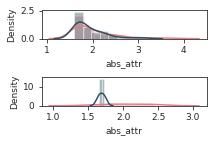

In [37]:
# dt = res.loc[res['abs_attr']>=res['abs_attr'].quantile(0.9999)]
dt = res.loc[res['abs_attr'].to_numpy().argsort()[::-1].argsort() < 200]

fig, ax = plt.subplots(2, 1, figsize=(3,2))
sns.distplot(dt.loc[(dt['sleep']==0) & (dt['group']=='Higher-than-actual'), 'abs_attr'], color='#E57F84', label='Higher-than-actual', ax=ax[0])
sns.distplot(dt.loc[(dt['sleep']==0) & (dt['group']=='Lower-than-actual'), 'abs_attr'], color='#2F5061', label='Lower-than-actual', ax=ax[0])

sns.distplot(dt.loc[(dt['sleep']==1) & (dt['group']=='Higher-than-actual'), 'abs_attr'], color='#E57F84', label='Higher-than-actual', ax=ax[1])
sns.distplot(dt.loc[(dt['sleep']==1) & (dt['group']=='Lower-than-actual'), 'abs_attr'], color='#2F5061', label='Lower-than-actual', ax=ax[1])
fig.tight_layout()

fig.savefig(os.path.join(pfp, 'distplot_wakeVsleep_errgrp_upperthousandth_v71.pdf'))

In [169]:
# sns.distplot(
#     res.loc[((
#     ((res['attr'] >= (1e-12)) & (res['attr']>=0)) | 
#     ((res['attr'] <= -(1e-12)) & (res['attr']<0))) & 
#     (res['sleep']==0) & (res['group']=='Higher-than-actual')), 'attr'], color='#333652', label='Higher-than-actual')
# sns.distplot(
#     res.loc[((
#     ((res['attr'] >= (1e-12)) & (res['attr']>=0)) | 
#     ((res['attr'] <= -(1e-12)) & (res['attr']<0))) & 
#     (res['sleep']==0) & (res['group']=='Lower-than-actual')), 'attr'], color='#90ADC6', label='Lower-than-actual')

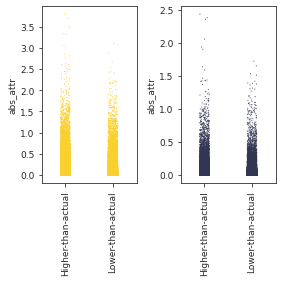

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(4, 4))
sns.stripplot(x='group', y='abs_attr', 
              data=res.loc[((
    ((res['attr'] >= (1e-12)) & (res['attr']>=0)) | 
    ((res['attr'] <= -(1e-12)) & (res['attr']<0))) & 
    (res['sleep']==0)), :], 
              hue='sleep', rasterized=True, s=1, ax=ax[0], palette={0:'#FAD02C', 1:'#333652'},
             )
sns.stripplot(x='group', y='abs_attr', 
              data=res.loc[((
    ((res['attr'] >= (1e-12)) & (res['attr']>=0)) | 
    ((res['attr'] <= -(1e-12)) & (res['attr']<0))) & 
    (res['sleep']==1)), :], 
              hue='sleep', rasterized=True, s=1, ax=ax[1], palette={0:'#FAD02C', 1:'#333652'},
             )
ax[0].legend().set_visible(False)
ax[1].legend().set_visible(False)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
fig.tight_layout()
fig.savefig(os.path.join(pfp, 'stripplot_featattrVerrorgrp_v71.pdf'))

In [39]:
n_comparisons = 4
# sleep
a = res.loc[(res['group']=='High actigraphy-GA') & (res['sleep']==1), 'attr'].to_numpy()
b = res.loc[(res['group']=='Low actigraphy-GA') & (res['sleep']==1), 'attr'].to_numpy()

statistic, p = mannwhitneyu(a, b)
p = p*n_comparisons
p

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/scipy/stats/stats.py:7171: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


0.0

In [43]:
# sleep, groupbed by uid
a = res.loc[(res['group']=='Higher-than-actual') & (res['sleep']==1), :].groupby('uid').mean()['attr'].to_numpy()
b = res.loc[(res['group']=='Lower-than-actual') & (res['sleep']==1), :].groupby('uid').mean()['attr'].to_numpy()

mannwhitneyu(a, b)

MannwhitneyuResult(statistic=1951.0, pvalue=0.1865315698368174)

In [44]:
# wake
a = res.loc[(res['group']=='Higher-than-actual') & res['sleep']!=1, 'attr'].to_numpy()
b = res.loc[(res['group']=='Lower-than-actual') & res['sleep']!=1, 'attr'].to_numpy()

mannwhitneyu(a, b)

MannwhitneyuResult(statistic=853910117655.0, pvalue=0.044223390911256065)

In [45]:
# wake, grouped by uid
a = res.loc[(res['group']=='Higher-than-actual') & (res['sleep']!=1), :].groupby('uid').mean()['attr'].to_numpy()
b = res.loc[(res['group']=='Lower-than-actual') & (res['sleep']!=1), :].groupby('uid').mean()['attr'].to_numpy()

mannwhitneyu(a, b)

MannwhitneyuResult(statistic=1940.0, pvalue=0.21159916264630463)

In [153]:
# sleep - wake, grouped by uid
a = (res.loc[(res['group']=='Higher-than-actual') & (res['sleep']==1), :].groupby('uid').mean()['attr'] - res.loc[(res['group']=='High actigraphy-GA') & (res['sleep']!=1), :].groupby('uid').mean()['attr']).to_numpy()
b = (res.loc[(res['group']=='Lower-than-actual') & (res['sleep']==1), :].groupby('uid').mean()['attr'] - res.loc[(res['group']=='Low actigraphy-GA') & (res['sleep']!=1), :].groupby('uid').mean()['attr']).to_numpy()

mannwhitneyu(a, b)

MannwhitneyuResult(statistic=197.0, pvalue=1.6605959334977366e-19)

# questions

## association btw importance and time of (...)

time of day: weekend vs. weekday, morning vs. evening, sleep v. wake; day vs. night

In [47]:
def featattr_peruid(X, md, uids, explainer, trainer):
    '''
    Returns:
      df (pd.DataFrame)
      uids (dict): 'groupname': list of unique ids
    '''
    total_t = time.time()
    df = pd.DataFrame()
    counter = 0
    for i, g in enumerate(uids.keys()):
        for uid in uids[g]:
            idx = np.where(md.index==uid)[0].item()
            x = X[idx, :, :].unsqueeze(0)
            x.requires_grad = True
            print('starting idx: {}, unique id: {}\t{:.2f}-min elapsed'.format(idx, uid, (time.time()-total_t)/60))
            
            if counter==0: # only need to call once, unless want to add salt & pepper noise
                x_baseline = torch.zeros_like(x)
                x_baseline.requires_grad = True
                
            attr = explainer.attributions(input_tensor=x,
                                          baseline=x_baseline,
                                          num_samples=20,
                                          use_expectation=True,
                                          output_indices=0)
            dt = pd.DataFrame(attr[0, 0, :].detach().numpy(), columns=['attr'])
            dt['uid'] = uid
            
            # sleep or wake
            dt['sleep'] = trainer.data.data['data'][uid]['sleep'][:-1].to_numpy()
            
            t = trainer.data.data['data'][uid]['t'][:-1]
            dt['t'] = t.to_list() # does this preserve?
            
            # morning or evening
            dt['morningVevening'] = 'NA'
            dt.loc[((t.apply(lambda x: x.time()) >= datetime.time(hour=6)) & (t.apply(lambda x: x.time()) < datetime.time(hour=12))).to_list(),
                   'morningVevening'] = 'Morning'
            dt.loc[((t.apply(lambda x: x.time()) >= datetime.time(hour=18)) & (t.apply(lambda x: x.time()) <= datetime.time(hour=23, minute=59))).to_list(),
                   'morningVevening'] = 'Evening'
            
            # weekday or weekend
            dt['weekdayVweekend'] = 'Weekday'
            dt.loc[((t.apply(lambda x: x.weekday()) == 5) | (t.apply(lambda x: x.weekday()) == 6)).to_list(),
                   'weekdayVweekend'] = 'Weekend'
            
            # daytime, nighttime
            dt['dayVnight'] = 'Night'
            dt.loc[((t.apply(lambda x: x.time()) >= datetime.time(hour=6)) & (t.apply(lambda x: x.time()) < datetime.time(hour=18))).to_list(), 
                   'dayVnight'] = 'Day'
            
            dt['group'] = g
            df = df.append(dt)
            counter += 1
    return df

In [48]:
# sample low error group, then examine globally on them:
n_samples = 100
lt4wk = {'lt4wk': md_model.loc[(md_model['error'].abs() <= 4), :].sample(n_samples, replace=False).index.to_list(),
         'gt4wk': md_model.loc[(md_model['error'].abs() > 4), :].sample(n_samples, replace=False).index.to_list()}

In [49]:
res_lt4wk = featattr_peruid(X, md_model, lt4wk, explainer, trainer)

starting idx: 453, unique id: 2354_34	0.00-min elapsed
starting idx: 255, unique id: 1309_12	0.15-min elapsed
starting idx: 1368, unique id: 2566_23	0.30-min elapsed
starting idx: 537, unique id: 1488_25	0.44-min elapsed
starting idx: 338, unique id: 2328_25	0.57-min elapsed
starting idx: 862, unique id: 2159_13	0.70-min elapsed
starting idx: 1148, unique id: 2400_18	0.83-min elapsed
starting idx: 1347, unique id: 1335_32	0.96-min elapsed
starting idx: 1150, unique id: 2051_12	1.09-min elapsed
starting idx: 1389, unique id: 1018_19	1.22-min elapsed
starting idx: 1261, unique id: 1355_21	1.35-min elapsed
starting idx: 427, unique id: 2412_19	1.49-min elapsed
starting idx: 1225, unique id: 1421_10	1.62-min elapsed
starting idx: 196, unique id: 1853_23	1.75-min elapsed
starting idx: 974, unique id: 1052_33	1.89-min elapsed
starting idx: 1349, unique id: 2252_10	2.02-min elapsed
starting idx: 693, unique id: 1297_20	2.15-min elapsed
starting idx: 784, unique id: 1732_16	2.28-min elapsed
st

In [50]:
# redo error group, keep low error grp
n_samples = 100
error_grps = {}
for g in md_model['Error group'].unique():
    error_grps[g] = md_model.loc[(md_model['Error group'] == g)].index.to_list()
error_grp_sample = {k:list(np.random.choice(error_grps[k], n_samples)) for k in error_grps.keys()}
res = featattr_peruid(X, md_model, error_grp_sample, explainer, trainer)

starting idx: 271, unique id: 1505_31	0.00-min elapsed
starting idx: 38, unique id: 1173_25	0.13-min elapsed
starting idx: 526, unique id: 1401_30	0.26-min elapsed
starting idx: 477, unique id: 1190_25	0.40-min elapsed
starting idx: 1123, unique id: 2519_23	0.53-min elapsed
starting idx: 564, unique id: 1009_8	0.66-min elapsed
starting idx: 930, unique id: 2195_24	0.79-min elapsed
starting idx: 774, unique id: 2232_22	0.92-min elapsed
starting idx: 771, unique id: 2284_9	1.05-min elapsed
starting idx: 1209, unique id: 1676_13	1.18-min elapsed
starting idx: 286, unique id: 2413_26	1.31-min elapsed
starting idx: 1092, unique id: 2025_30	1.44-min elapsed
starting idx: 374, unique id: 1414_15	1.57-min elapsed
starting idx: 97, unique id: 2595_11	1.70-min elapsed
starting idx: 857, unique id: 2520_34	1.83-min elapsed
starting idx: 851, unique id: 2345_10	1.97-min elapsed
starting idx: 1180, unique id: 2153_13	2.10-min elapsed
starting idx: 1250, unique id: 2063_34	2.24-min elapsed
starting 

In [51]:
errgrp_ptb = {}
for g1 in ['Higher-than-actual', 'Lower-than-actual']:
    for g2 in [0, 1]:
        errgrp_ptb['{}_ptb{}'.format(g1, g2)] = md_model.loc[(md_model['Error group']==g1) & (md_model['ptb_37wks']==g2), :].index.to_list()
errgrp_ptb_sample = {k:list(np.random.choice(errgrp_ptb[k], n_samples)) for k in errgrp_ptb.keys()}
res_errgrp_ptb = featattr_peruid(X, md_model, errgrp_ptb_sample, explainer, trainer)

starting idx: 825, unique id: 2079_12	0.00-min elapsed
starting idx: 299, unique id: 2142_7	0.13-min elapsed
starting idx: 591, unique id: 1493_9	0.25-min elapsed
starting idx: 183, unique id: 1163_6	0.38-min elapsed
starting idx: 1027, unique id: 2109_8	0.51-min elapsed
starting idx: 51, unique id: 2207_7	0.64-min elapsed
starting idx: 902, unique id: 2277_8	0.78-min elapsed
starting idx: 202, unique id: 2303_7	0.91-min elapsed
starting idx: 835, unique id: 2258_5	1.03-min elapsed
starting idx: 1027, unique id: 2109_8	1.16-min elapsed
starting idx: 152, unique id: 1826_6	1.29-min elapsed
starting idx: 202, unique id: 2303_7	1.42-min elapsed
starting idx: 131, unique id: 1821_10	1.56-min elapsed
starting idx: 580, unique id: 2527_8	1.69-min elapsed
starting idx: 1367, unique id: 1689_6	1.82-min elapsed
starting idx: 138, unique id: 1398_9	1.95-min elapsed
starting idx: 1027, unique id: 2109_8	2.08-min elapsed
starting idx: 388, unique id: 1434_6	2.21-min elapsed
starting idx: 443, uniq

In [52]:
# interim save, due to time-consuming process
fname = 'featattr_res_220923.pkl'
results_all = {'res_4wk': res_lt4wk, 'res_err_grps': res, 'res_errgrp_ptb': res_errgrp_ptb}
with open(os.path.join(pfp, fname), 'wb') as f:
    pickle.dump(results_all, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

In [53]:
!mail -s "results_saved" ngravindra@gmail.com <<< "dumpy batch"

In [54]:
res_lt4wk.head()

,attr,uid,sleep,t,morningVevening,weekdayVweekend,dayVnight,group
0,0.005186,2354_34,1,2019-01-15 00:00:00,NA,Weekday,Night,lt4wk
1,-0.006501,2354_34,1,2019-01-15 00:01:00,NA,Weekday,Night,lt4wk
2,0.000000,2354_34,1,2019-01-15 00:02:00,NA,Weekday,Night,lt4wk
3,0.000000,2354_34,1,2019-01-15 00:03:00,NA,Weekday,Night,lt4wk
4,0.000000,2354_34,1,2019-01-15 00:04:00,NA,Weekday,Night,lt4wk


In [55]:
res_lt4wk.group.unique()

array(['lt4wk', 'gt4wk'], dtype=object)

In [56]:
sleep_cmap = {0:'#FAD02C', 1:'#333652'}
res_lt4wk['abs_attr'] = res_lt4wk['attr'].abs()

In [57]:
def imp_panel(df, grp, out_file=None):
    fig = plt.figure(figsize=(13.5,4))
    for i, g in enumerate(['morningVevening', 'weekdayVweekend', 'dayVnight']):
        ax = fig.add_subplot(1, 4, i+1)
        sns.stripplot(x=g, y='abs_attr', 
                      data=df.loc[(df[g]!='NA') & (df['group']==grp)] if g=='morningVevening' else df.loc[df['group']==grp, :], 
                      s=1, 
                      rasterized=True, 
                      hue='sleep', 
                      dodge=True, 
                      palette=sleep_cmap,
                      ax=ax,
                      zorder=0,)
    #     sns.boxplot(x=g, y='attr', 
    #                 data=res_lt2wk.loc[res_lt2wk[g]!='NA'] if g=='morningVevening' else res_lt2wk,
    #                 boxprops={'facecolor':'none', 'edgecolor':'gray'},
    #                 linewidth=2,
    #                 hue='sleep',
    #                 showfliers=False,
    #                 dodge=True,
    #                 palette=sleep_cmap,
    #                 zorder=1)
        sns.barplot(x=g, y='abs_attr', 
                    data=df.loc[(df[g]!='NA') & (df['group']==grp)] if g=='morningVevening' else df.loc[df['group']==grp, :],
                    facecolor='none', edgecolor='gray',
                    errwidth=2,
                    errcolor='gray',
                    linewidth=2,
                    hue='sleep',
                    dodge=True,
                    ci='sd',
                    palette=sleep_cmap,
                    zorder=1)
        ax.legend().set_visible(False)
        ax.set_xlabel('')
        ax.set_ylabel('Feature importance')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax = fig.add_subplot(1, 4, 4)
    sns.stripplot(x='sleep', y='abs_attr', 
                      data=df.loc[df['group']==grp, :], 
                      s=1, 
                      rasterized=True, 
                      hue='sleep', 
                      dodge=False, 
                      palette=sleep_cmap,
                      ax=ax,
                      zorder=0,)
    sns.barplot(x='sleep', y='abs_attr', 
                data=df.loc[df['group']==grp, :],
                facecolor='none', edgecolor='gray',
                errwidth=2,
                errcolor='gray',
                linewidth=2,
                hue='sleep',
                ci='sd',
                dodge=False,
                palette=sleep_cmap,
                zorder=1)
    ax.legend().set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('Feature importance')

    fig.tight_layout()
    
    if out_file is not None:
        fig.savefig(out_file, bbox_inches='tight', dpi=600)

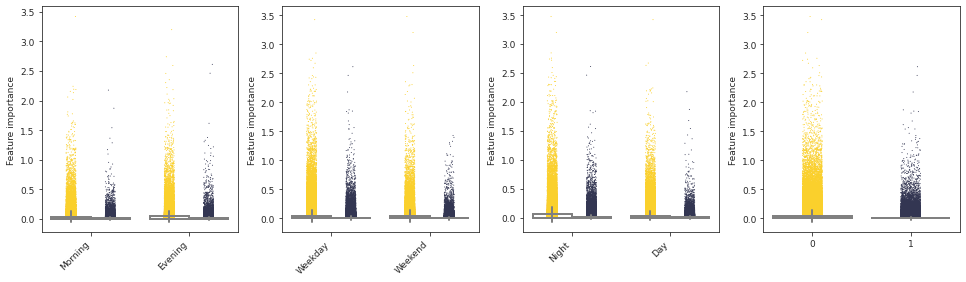

In [61]:
imp_panel(res_lt4wk, 'lt4wk', out_file=os.path.join(pfp, 'stripplots_feature_imp_V_tod_lt4wk_v71.pdf'))


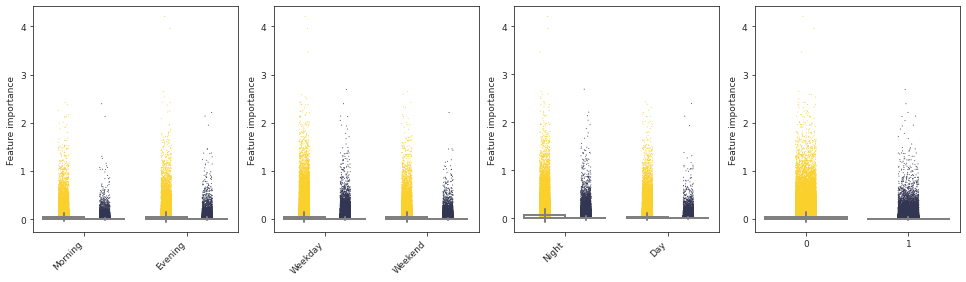

In [60]:
imp_panel(res_lt4wk, 'gt4wk', out_file=os.path.join(pfp, 'stripplots_feature_imp_V_tod_gt4wk_v71.pdf'))


### add corr vals to these?

In [67]:
import importlib
from wearables.scripts import correlate_tabular_data as weartabcorr
from wearables.scripts.md_specification import mdpred_voi_v2
importlib.reload(weartabcorr)

<module 'wearables.scripts.correlate_tabular_data' from '/home/ngrav/project/wearables/scripts/correlate_tabular_data.py'>

In [68]:
paired_cmap = ['#007172', '#F29325']


In [69]:
# load old data
fname = 'featattr_res_220923.pkl'

with open(os.path.join(pfp, fname), 'rb') as f:
    results_all = pickle.load(f)
    f.close()
    
res = results_all['res_err_grps']

md_coi = [i for i in list(mdpred_voi_v2.keys()) if i in md.columns]
res['abs_attr'] = res['attr'].abs()
dt = res.merge(md.loc[:, md_coi], left_on='uid', right_index=True, how='left')

# sample? takes too long otherwise
if True:
    dt = dt.sample(200000).reset_index()

In [70]:
dt['morningVevening'].unique()

array(['NA', 'Evening', 'Morning'], dtype=object)

In [71]:
a = weartabcorr.elasticnet(dt.loc[dt['morningVevening']=='Evening', :], 'abs_attr', 'sleep')
b = weartabcorr.elasticnet(dt.loc[dt['morningVevening']=='Morning', :], 'abs_attr', 'sleep')

Text(0, 0.5, 'TPR')

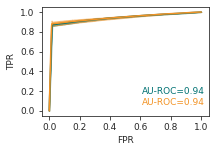

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
# case 1
ax.plot(a[0], np.mean(a[1], 0), color=paired_cmap[0])
ax.fill_between(a[0], np.mean(a[1], 0) - np.std(a[1], 0), np.mean(a[1], 0) + np.std(a[1], 0), color=paired_cmap[0], alpha=0.5)
ax.text(0.6, 0.2, f'AU-ROC={np.mean(a[2]):.2f}', transform=ax.transAxes, color=paired_cmap[0]) #  ({np.std(mve[2]):.1f})
# case 2
ax.plot(b[0], np.mean(b[1], 0), color=paired_cmap[1])
ax.fill_between(b[0], np.mean(b[1], 0) - np.std(b[1], 0), np.mean(b[1], 0) + np.std(b[1], 0), color=paired_cmap[1], alpha=0.5)
ax.text(0.6, 0.1, f'AU-ROC={np.mean(b[2]):.2f}', transform=ax.transAxes, color=paired_cmap[1]) #  ({np.std(mve[2]):.1f})

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

### show prop zero instead 

In [82]:
slp_cmap = {'Wake':'#FAD02C', 'Sleep':'#333652'}

In [80]:
savefigs = True

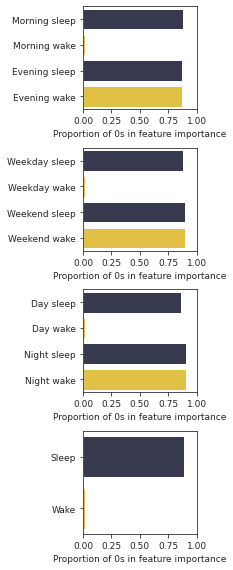

In [83]:
tol = 1e-8
specs = {'morningVevening': ['Morning', 'Evening'],
         'weekdayVweekend': ['Weekday', 'Weekend'],
         'dayVnight': ['Day', 'Night'],
         'sleep': [1, 0],}
fig = plt.figure(figsize=(3, 8))
for i, (k, v) in enumerate(specs.items()):
    ax = fig.add_subplot(4, 1, i+1)
    if k!='sleep':
        p_a1 = (dt.loc[(dt[k]==v[0]) & (dt['sleep']==1), 'abs_attr'] <= tol).sum() / dt.loc[(dt[k]==v[0]) & (dt['sleep']==1), 'abs_attr'].shape[0]
        p_a0 = (dt.loc[(dt[k]==v[0]) & (dt['sleep']==0), 'abs_attr'] <= tol).sum() / dt.loc[(dt[k]==v[0]) & (dt['sleep']==0), 'abs_attr'].shape[0]
        p_b1 = (dt.loc[(dt[k]==v[1]) & (dt['sleep']==1), 'abs_attr'] <= tol).sum() / dt.loc[(dt[k]==v[1]) & (dt['sleep']==1), 'abs_attr'].shape[0]
        p_b0 = (dt.loc[(dt[k]==v[1]) & (dt['sleep']==0), 'abs_attr'] <= tol).sum() / dt.loc[(dt[k]==v[1]) & (dt['sleep']==0), 'abs_attr'].shape[0]
        grp = []
        for i in specs[k]:
            grp.append(i + ' sleep')
            grp.append(i + ' wake')
        dtt = pd.DataFrame({'Proportion of 0s': [p_a1, p_a0, p_b1, p_b1], 'Group': grp,
                            'slp': ['Sleep', 'Wake']*2})
    else:
        p_a = (dt.loc[(dt[k]==v[0]), 'abs_attr'] <= tol).sum() / dt.loc[(dt[k]==v[0]), 'abs_attr'].shape[0]
        p_b = (dt.loc[(dt[k]==v[1]), 'abs_attr'] <= tol).sum() / dt.loc[(dt[k]==v[1]), 'abs_attr'].shape[0]
        dtt = pd.DataFrame({'Proportion of 0s': [p_a, p_b], 'Group': ['Sleep', 'Wake'],
                            'slp': ['Sleep', 'Wake']})
    sns.barplot(x='Proportion of 0s', y='Group', data=dtt, hue='slp', 
                dodge=False, palette=slp_cmap)#palette={kk: paired_cmap[i] for i, kk in enumerate(specs[k])})
    ax.set_ylabel('')
    ax.set_xlim([0, 1])
    ax.legend().set_visible(False)
    ax.set_xlabel('Proportion of 0s in feature importance')
    
fig.tight_layout()

if savefigs:
    fig.savefig(os.path.join(pfp, 'barplot_todgrpVp0_v71.pdf'), bbox_inches='tight')
    

## feat attr V. clinical var

NOTE: for doubling the length of sample, it is roughly doubling the computation time... thus... the algorithm is linear. 

In [398]:
# exclude_md_vars = ['record_id', 'split', 'y'] + [i for i in res.columns if i in md.columns]
# coi = [i for i in md.columns if i not in exclude_md_vars]

In [399]:
from wearables.scripts.md_specification import mdpred_voi_v2
from wearables.scripts import correlate_tabular_data as weartabcorr

In [84]:
# load old data
fname = 'featattr_res_220923.pkl'

with open(os.path.join(pfp, fname), 'rb') as f:
    results_all = pickle.load(f)
    f.close()
    
res = results_all['res_err_grps']

In [85]:
res.head()

,attr,uid,sleep,t,morningVevening,weekdayVweekend,dayVnight,group
0,0.0,1505_31,1,2019-01-05 00:00:00,NA,Weekend,Night,lt10wks
1,0.0,1505_31,1,2019-01-05 00:01:00,NA,Weekend,Night,lt10wks
2,0.0,1505_31,1,2019-01-05 00:02:00,NA,Weekend,Night,lt10wks
3,0.0,1505_31,1,2019-01-05 00:03:00,NA,Weekend,Night,lt10wks
4,0.0,1505_31,1,2019-01-05 00:04:00,NA,Weekend,Night,lt10wks


In [86]:
md_coi = [i for i in list(mdpred_voi_v2.keys()) if i in md.columns]
res['abs_attr'] = res['attr'].abs()
dt = res.merge(md.loc[:, md_coi], left_on='uid', right_index=True, how='left')

# sample? takes too long otherwise
if True:
    dt = dt.sample(200000).reset_index()

In [87]:
dt.head()

,index,attr,uid,sleep,t,morningVevening,weekdayVweekend,dayVnight,group,abs_attr,...,ave_logpseudocount_wkday,ave_logpseudocount_day,ave_logpseudocount_night,PQSI,KPAS,EpworthSS,Edinburgh,GA,yhat,error
0,1697,0.000000,1322_25,1,2018-03-31 04:17:00,NA,Weekend,Night,lt10wks,0.000000,...,2.341953,2.720885,2.656495,8.0,8.325541,7.0,0.0,25.0,22.108198,-2.891802
1,8117,0.008939,1328_23,0,2018-03-27 15:17:00,NA,Weekday,Day,lt10wks,0.008939,...,3.187639,4.629515,1.831883,4.0,4.571429,0.0,0.0,23.0,16.403538,-6.596462
2,2540,-0.062306,1038_7,0,2017-03-26 18:20:00,Evening,Weekend,Night,Higher-than-actual,0.062306,...,1.296104,2.280878,0.984629,10.0,8.454762,2.0,0.0,7.0,19.040159,12.040159
3,3377,0.000000,2248_24,1,2018-07-20 08:17:00,Morning,Weekday,Day,lt10wks,0.000000,...,3.332354,4.341745,2.176942,7.0,11.509870,11.0,3.0,24.0,21.711708,-2.288292
4,9651,0.030110,2385_10,0,2018-10-09 16:51:00,NA,Weekday,Day,Higher-than-actual,0.030110,...,2.775276,4.048339,1.436117,11.0,10.649495,4.0,1.0,10.0,20.535717,10.535717


In [ ]:
# the all grouping will be redundant but OH WELL
for g in ['morningVevening', 'weekdayVweekend', 'dayVnight', 'sleep', 'group']:
    results_all['impcorr_{}'.format(g)] = weartabcorr.colVall_corr(dt, 'abs_attr', mdpred_voi_v2, groupby=g)

Starting grp: all
  through 1 of 129 vars in 0-s
  through 51 of 129 vars in 282-s
  through 101 of 129 vars in 1337-s

  ... through grp all in 25.3-min
Starting grp: NA
  through 1 of 129 vars in 0-s
  through 51 of 129 vars in 99-s
  through 101 of 129 vars in 476-s

only one val for morningVevening
... cannot fit one class only. Reconsider its inclusion. Skipping this var.

  ... through grp NA in 8.8-min
Starting grp: Evening
  through 1 of 129 vars in 0-s
  through 51 of 129 vars in 35-s
  through 101 of 129 vars in 160-s

only one val for morningVevening
... cannot fit one class only. Reconsider its inclusion. Skipping this var.

only one val for dayVnight
... cannot fit one class only. Reconsider its inclusion. Skipping this var.

  ... through grp Evening in 2.9-min
Starting grp: Morning
  through 1 of 129 vars in 0-s
  through 51 of 129 vars in 40-s
  through 101 of 129 vars in 161-s

only one val for morningVevening
... cannot fit one class only. Reconsider its inclusion. Sk

In [ ]:
errcor_vois = {}
for i in mdpred_voi_v2.keys():
    if i in md.columns:
        errcor_vois[i] = mdpred_voi_v2[i]


In [ ]:
# add md corr as well but for the error 
errgrpcorr = weartabcorr.colVall_corr(md, 'error', errcor_vois, groupby='Error group')
results_all['errcorr'] = errgrpcorr

In [ ]:
# interim save, due to time-consuming process
fname = 'featattr_res_220923_2.pkl'
with open(os.path.join(pfp, fname), 'wb') as f:
    pickle.dump(results_all, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

In [ ]:
!mail -s "done with the corr of imp and err with md and other grps" ngravindra@gmail.com <<< "4theplots, you batch"

In [ ]:
# now with err group
# the all grouping will be redundant but OH WELL
for g in ['morningVevening', 'weekdayVweekend', 'dayVnight', 'sleep', 'group']:
    results_all['errcorr_{}'.format(g)] = weartabcorr.colVall_corr(dt, 'error', mdpred_voi_v2, groupby=g)

In [ ]:
# interim save, due to time-consuming process
fname = 'featattr_res_220923_3.pkl'
with open(os.path.join(pfp, fname), 'wb') as f:
    pickle.dump(results_all, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

In [ ]:
!mail -s "done with the corr of err with other grps" ngravindra@gmail.com <<< "4theplots, you batch"

In [91]:
print('here')

here


## association of (imp OR err) AND (md OR err grp)

### error correlations with (md_vars OR err_grp)

in main, show key ones. Bury others in supplement and show some specific distributions in main plot

In [97]:
from wearables.scripts.aesthetics import md_node_annotation, md_node_category_cmap
grp_cmap = {
    'all': '#F67280',
    'Higher-than-actual': '#C06C84',
    'Lower-than-actual': '#6C5B7B',
    'lt10wks': '#355C7D',
}

In [98]:
results_all.keys()

dict_keys(['res_4wk', 'res_err_grps', 'res_errgrp_ptb', 'impcorr_morningVevening', 'impcorr_weekdayVweekend', 'impcorr_dayVnight', 'impcorr_sleep', 'impcorr_group', 'errcorr', 'errcorr_morningVevening', 'errcorr_weekdayVweekend', 'errcorr_dayVnight', 'errcorr_sleep', 'errcorr_group'])

In [99]:
# g = sns.FacetGrid(data=dt.loc[dt['variable']!='all'], row='variable', col='cat', hue='cat', palette=md_node_category_cmap)
# g = sns.FacetGrid(data=dt.loc[dt['variable']=='diff_slpVwake'], row='variable', col='cat', hue='cat', palette=md_node_category_cmap)
# g.map(sns.barplot, 'index', 'value', dodge=True)
# for axes in g.axes.flat:
#     axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
#     axes.set_xlabel('')
    

In [100]:
savefigs = True

In [101]:
diff_specs = {'errcorr_morningVevening': ['Morning', 'Evening'], 
              'errcorr_weekdayVweekend': ['Weekday', 'Weekend'],
              'errcorr_dayVnight': ['Day', 'Night'],
              'errcorr_sleep': [1, 0],
              'errcorr_group': []}

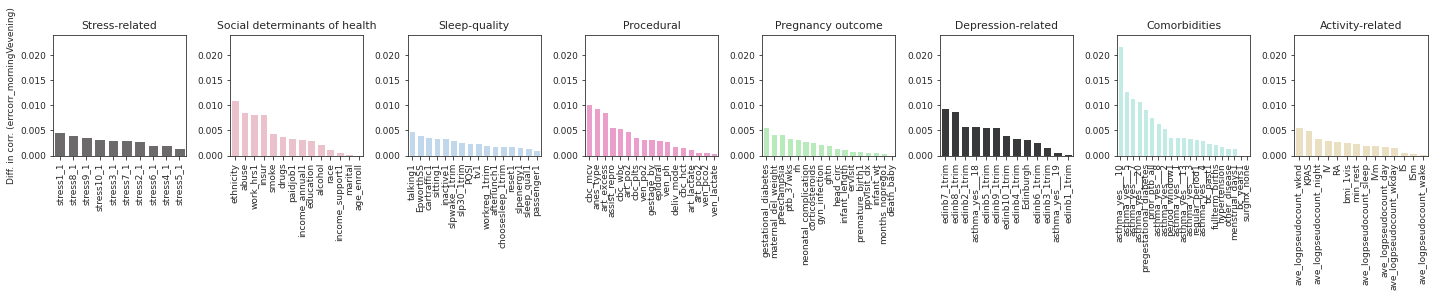

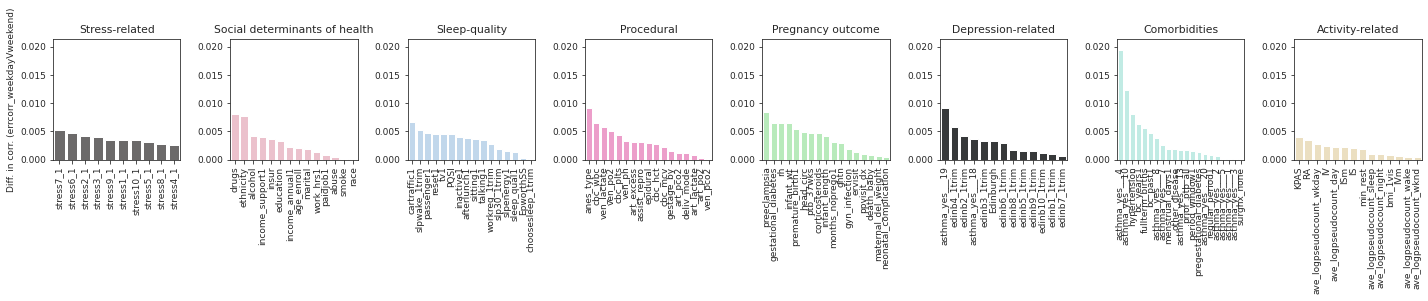

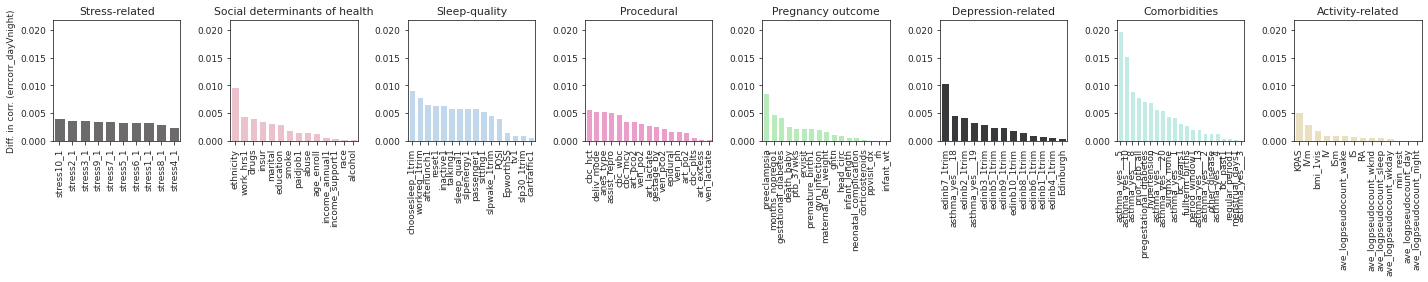

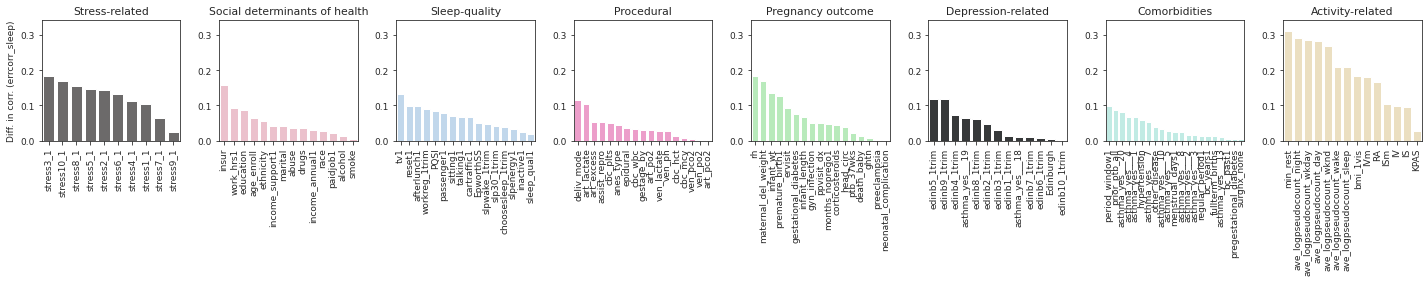

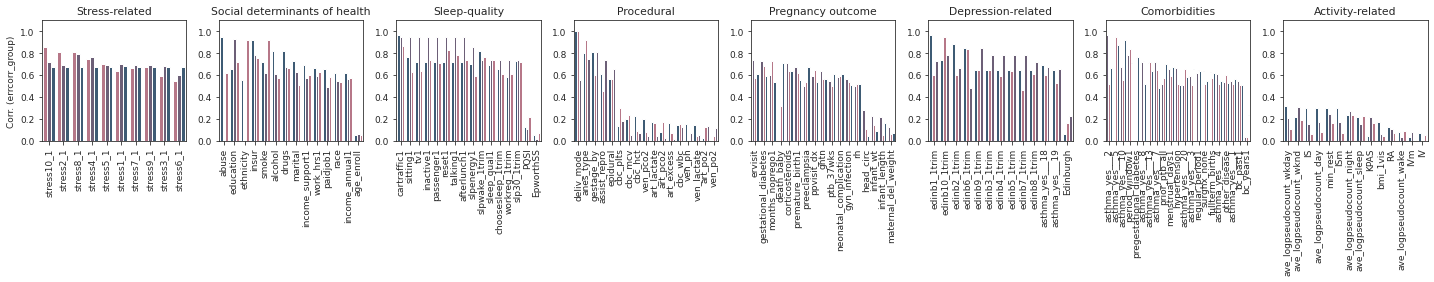

In [102]:
# wrangle df
for k_a, v in diff_specs.items():
    dt = results_all[k_a]
    if len(v) > 0:
        dt['diff'] = dt[v[0]] - dt[v[1]]
    dt['cat'] = dt.index.map(md_node_annotation)
    dt = dt.loc[~dt['cat'].isna()]
    dt = dt.reset_index().melt(id_vars=['cat', 'index'])
    dt['value'] = dt['value'].abs()
    dt = dt.sort_values(by=['cat', 'value'], ascending=False)

    # plot
    if len(v) > 0:
        dtt = dt.loc[(dt['variable']=='diff')]
    else:
        dtt = dt.loc[dt['variable']!='all']

    fig = plt.figure(figsize=(20, 4))
    for i, cat in enumerate(dt['cat'].unique()):
        ax = fig.add_subplot(1, 8, i+1)
        if len(v) > 0:
            sns.barplot(x='index', y='value', data=dtt.loc[(dtt['cat']==cat)], hue='cat', palette=md_node_category_cmap, ax=ax)
        else:
            sns.barplot(x='index', y='value', data=dtt.loc[(dtt['cat']==cat)], hue='variable', palette=grp_cmap, ax=ax)
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        if i==0:
            if len(v) > 0:
                ax.set_ylabel(f'Diff. in corr. ({k_a})')
            else:
                ax.set_ylabel(f'Corr. ({k_a})')
        else:
            ax.set_ylabel('')
        ax.legend().set_visible(False)
        ax.set_title(cat)
        ax.set_ylim([0, 0.1*np.max(dtt['value'])+np.max(dtt['value'])])
    fig.tight_layout()
    
    if savefigs:
        fig.savefig(os.path.join(pfp, 'barplot_{}v71.pdf'.format(k_a)), bbox_inches='tight', dpi=600)

## importance correlations

### impcorr with (md_vars OR err grp) 

In [103]:
diff_specs = {'impcorr_morningVevening': ['Morning', 'Evening'], 
              'impcorr_weekdayVweekend': ['Weekday', 'Weekend'],
              'impcorr_dayVnight': ['Day', 'Night'],
              'impcorr_sleep': [1, 0],
              'impcorr_group': []}

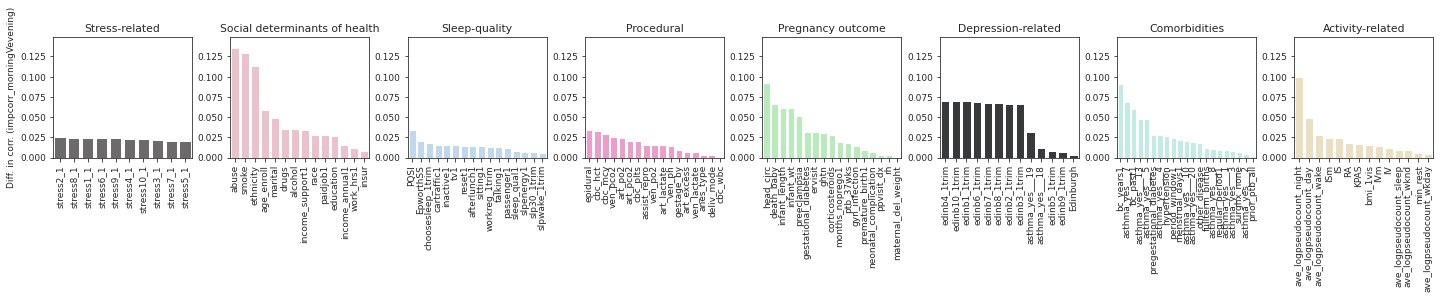

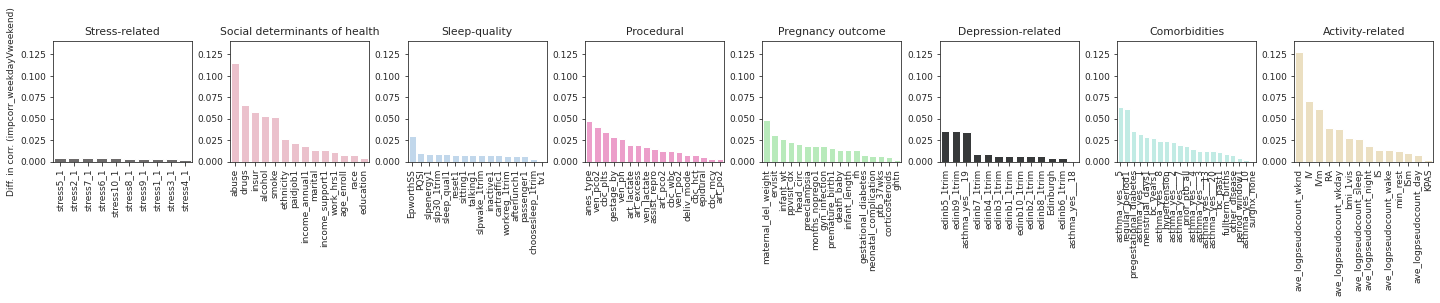

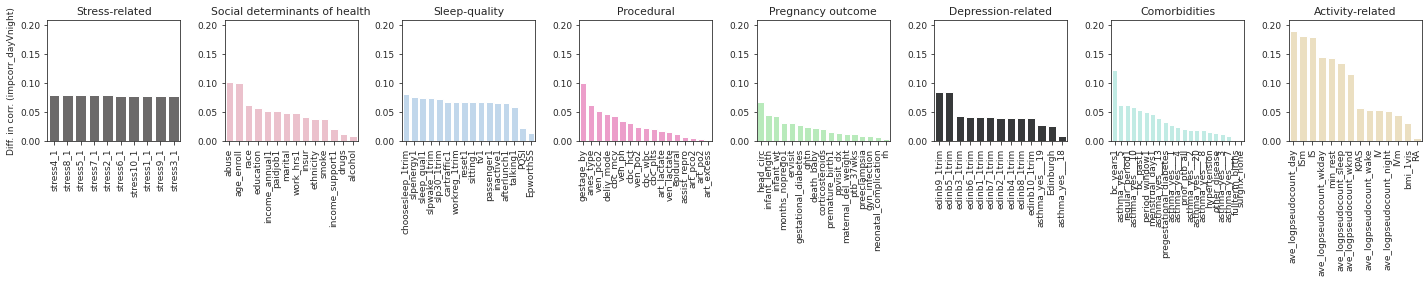

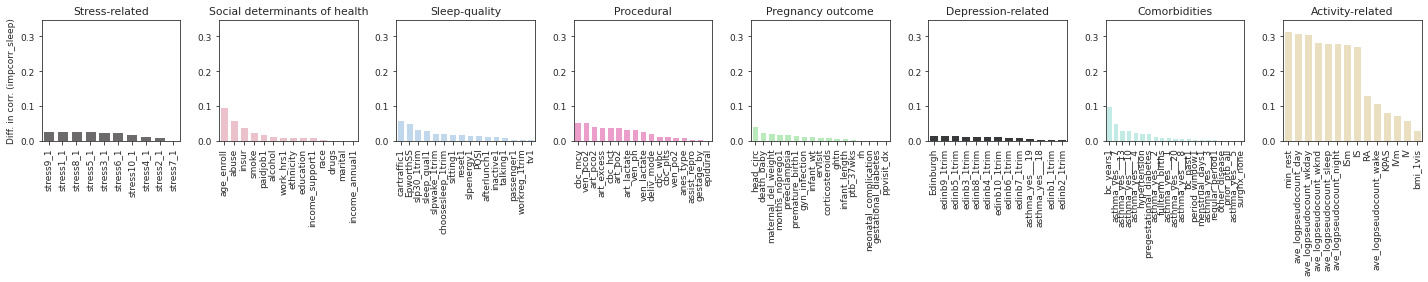

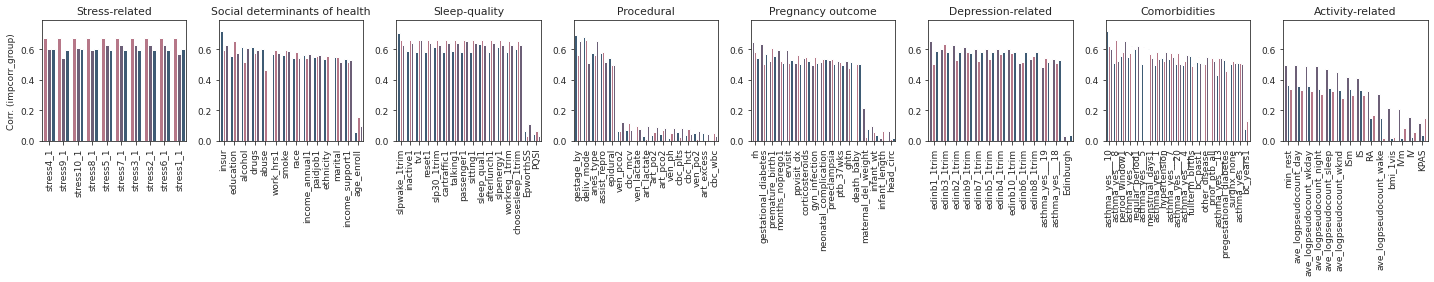

In [104]:
# wrangle df
for k_a, v in diff_specs.items():
    dt = results_all[k_a]
    if len(v) > 0:
        dt['diff'] = dt[v[0]] - dt[v[1]]
    dt['cat'] = dt.index.map(md_node_annotation)
    dt = dt.loc[~dt['cat'].isna()]
    dt = dt.reset_index().melt(id_vars=['cat', 'index'])
    dt['value'] = dt['value'].abs()
    dt = dt.sort_values(by=['cat', 'value'], ascending=False)

    # plot
    if len(v) > 0:
        dtt = dt.loc[(dt['variable']=='diff')]
    else:
        dtt = dt.loc[dt['variable']!='all']

    fig = plt.figure(figsize=(20, 4))
    for i, cat in enumerate(dt['cat'].unique()):
        ax = fig.add_subplot(1, 8, i+1)
        if len(v) > 0:
            sns.barplot(x='index', y='value', data=dtt.loc[(dtt['cat']==cat)], hue='cat', palette=md_node_category_cmap, ax=ax)
        else:
            sns.barplot(x='index', y='value', data=dtt.loc[(dtt['cat']==cat)], hue='variable', palette=grp_cmap, ax=ax)
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        if i==0:
            if len(v) > 0:
                ax.set_ylabel(f'Diff. in corr. ({k_a})')
            else:
                ax.set_ylabel(f'Corr. ({k_a})')
        else:
            ax.set_ylabel('')
        ax.legend().set_visible(False)
        ax.set_title(cat)
        ax.set_ylim([0, 0.1*np.max(dtt['value'])+np.max(dtt['value'])])
    fig.tight_layout()
    
    if savefigs:
        fig.savefig(os.path.join(pfp, 'barplot_{}v71.pdf'.format(k_a)), bbox_inches='tight', dpi=600)

## specifics of imp/err corr by errgrp

In [105]:
results_all.keys()

dict_keys(['res_4wk', 'res_err_grps', 'res_errgrp_ptb', 'impcorr_morningVevening', 'impcorr_weekdayVweekend', 'impcorr_dayVnight', 'impcorr_sleep', 'impcorr_group', 'errcorr', 'errcorr_morningVevening', 'errcorr_weekdayVweekend', 'errcorr_dayVnight', 'errcorr_sleep', 'errcorr_group'])

In [106]:
diff_specs = {'errcorr_morningVevening': ['Morning', 'Evening'], 
              'errcorr_weekdayVweekend': ['Weekday', 'Weekend'],
              'errcorr_dayVnight': ['Day', 'Night'],
              'errcorr_sleep': [1, 0],
              'errcorr_group': ['lt10wks', 'Lower-than-actual', 'Higher-than-actual'],
             
              'impcorr_morningVevening': ['Morning', 'Evening'], 
              'impcorr_weekdayVweekend': ['Weekday', 'Weekend'],
              'impcorr_dayVnight': ['Day', 'Night'],
              'impcorr_sleep': [1, 0],
              'impcorr_group': ['lt10wks', 'Lower-than-actual', 'Higher-than-actual']}

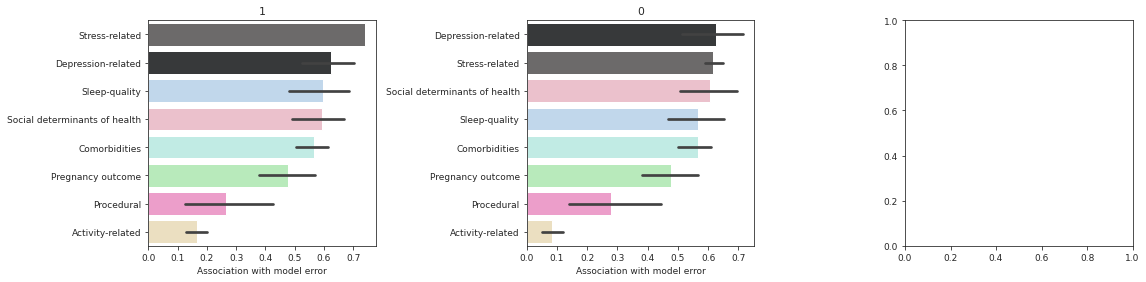

In [107]:
k_a = 'errcorr_sleep'
dt = results_all[k_a]
dt['cat'] = dt.index.map(md_node_annotation)
dt = dt.loc[~dt['cat'].isna()]
dt = dt.reset_index().melt(id_vars=['cat', 'index'])
dt['value'] = dt['value'].abs()
dt.head()

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for i, v in enumerate(diff_specs[k_a]):
    dtt = dt.loc[dt['variable']==v, :]
    # dtt['cat'] = pd.Categorical(dtt['cat'], 
    #            categories=dtt.groupby('cat')['value'].mean().reset_index().sort_values(by='cat', ascending=False)['cat'].to_list(),
    #            ordered=True)
    # dtt = dtt.groupby('cat')['value'].mean().reset_index()
    # dtt = dtt.sort_values(by='
    sns.barplot(y='cat', x='value',
                # estimator=np.max,
                data=dtt, 
                hue='cat', palette=md_node_category_cmap, 
                dodge=False, 
                ax=ax[i],
                order=dtt.groupby('cat')['value'].mean().reset_index().sort_values(by='value', ascending=False)['cat'].to_list())
    ax[i].legend().set_visible(False)
    ax[i].set_title(v)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('Association with model error')
    # del dtt
fig.tight_layout()


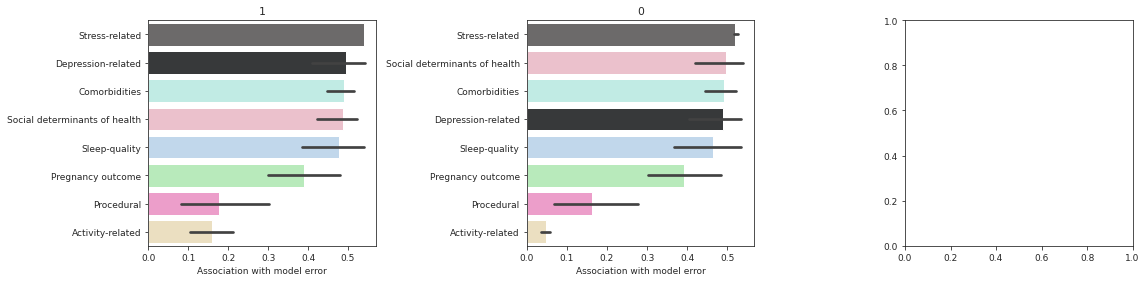

In [108]:
k_a = 'impcorr_sleep'
dt = results_all[k_a]
dt['cat'] = dt.index.map(md_node_annotation)
dt = dt.loc[~dt['cat'].isna()]
dt = dt.reset_index().melt(id_vars=['cat', 'index'])
dt['value'] = dt['value'].abs()
dt.head()

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for i, v in enumerate(diff_specs[k_a]):
    dtt = dt.loc[dt['variable']==v, :]
    sns.barplot(y='cat', x='value',
                # estimator=np.max,
                data=dtt, 
                hue='cat', palette=md_node_category_cmap, 
                dodge=False, 
                ax=ax[i],
                order=dtt.groupby('cat')['value'].mean().reset_index().sort_values(by='value', ascending=False)['cat'].to_list())
    ax[i].legend().set_visible(False)
    ax[i].set_title(v)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('Association with model error')
    # del dtt
fig.tight_layout()


In [109]:
dtt.loc[dt['cat']=='Stress-related']

,cat,index,variable,value
316,Stress-related,stress1_1,0,0.512805
317,Stress-related,stress2_1,0,0.529106
318,Stress-related,stress3_1,0,0.515158
319,Stress-related,stress4_1,0,0.527676
320,Stress-related,stress5_1,0,0.514032
321,Stress-related,stress6_1,0,0.514552
322,Stress-related,stress7_1,0,0.540017
323,Stress-related,stress8_1,0,0.51376
324,Stress-related,stress9_1,0,0.511905
325,Stress-related,stress10_1,0,0.520691


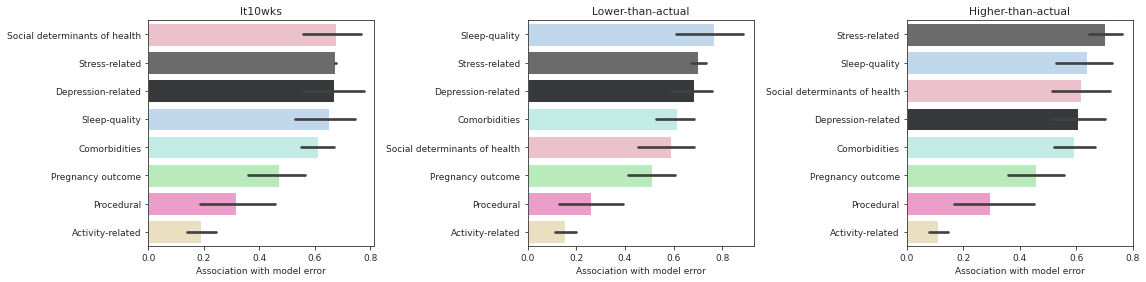

In [110]:
k_a = 'errcorr_group'
dt = results_all[k_a]
dt['cat'] = dt.index.map(md_node_annotation)
dt = dt.loc[~dt['cat'].isna()]
dt = dt.reset_index().melt(id_vars=['cat', 'index'])
dt['value'] = dt['value'].abs()
dt.head()

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for i, v in enumerate(['lt10wks', 'Lower-than-actual', 'Higher-than-actual']):
    dtt = dt.loc[dt['variable']==v, :]
    # dtt['cat'] = pd.Categorical(dtt['cat'], 
    #            categories=dtt.groupby('cat')['value'].mean().reset_index().sort_values(by='cat', ascending=False)['cat'].to_list(),
    #            ordered=True)
    # dtt = dtt.groupby('cat')['value'].mean().reset_index()
    # dtt = dtt.sort_values(by='
    sns.barplot(y='cat', x='value', 
                data=dtt, 
                hue='cat', palette=md_node_category_cmap, 
                dodge=False, 
                ax=ax[i],
                order=dtt.groupby('cat')['value'].mean().reset_index().sort_values(by='value', ascending=False)['cat'].to_list())
    ax[i].legend().set_visible(False)
    ax[i].set_title(v)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('Association with model error')
    # del dtt
fig.tight_layout()

if savefigs:
    fig.savefig(os.path.join(pfp, 'barplot_mdvarcatsVassoc_errorv71.pdf'), bbox_inches='tight', dpi=600)

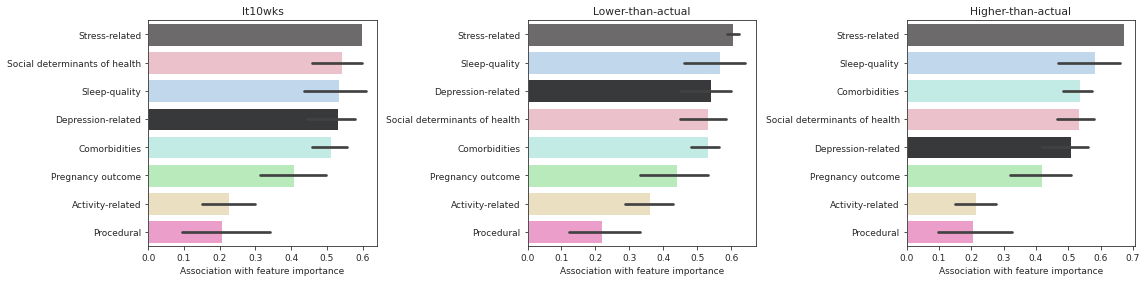

In [111]:
k_a = 'impcorr_group'
dt = results_all[k_a]
dt['cat'] = dt.index.map(md_node_annotation)
dt = dt.loc[~dt['cat'].isna()]
dt = dt.reset_index().melt(id_vars=['cat', 'index'])
dt['value'] = dt['value'].abs()
dt.head()

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for i, v in enumerate(['lt10wks', 'Lower-than-actual', 'Higher-than-actual']):
    dtt = dt.loc[dt['variable']==v, :]
    # dtt['cat'] = pd.Categorical(dtt['cat'], 
    #            categories=dtt.groupby('cat')['value'].mean().reset_index().sort_values(by='cat', ascending=False)['cat'].to_list(),
    #            ordered=True)
    # dtt = dtt.groupby('cat')['value'].mean().reset_index()
    # dtt = dtt.sort_values(by='
    sns.barplot(y='cat', x='value', 
                data=dtt, 
                hue='cat', palette=md_node_category_cmap, 
                dodge=False, 
                ax=ax[i],
                order=dtt.groupby('cat')['value'].mean().reset_index().sort_values(by='value', ascending=False)['cat'].to_list())
    ax[i].legend().set_visible(False)
    ax[i].set_title(v)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('Association with feature importance')
    # del dtt
fig.tight_layout()

if savefigs:
    fig.savefig(os.path.join(pfp, 'barplot_mdvarcatsVassoc_importancev71.pdf'), bbox_inches='tight', dpi=600)

## specifics of imp/err corr by sleep

### ptb and IS

In [112]:
md_coi = [i for i in list(mdpred_voi_v2.keys()) if i in md.columns]
res['abs_attr'] = res['attr'].abs()
dt = res.merge(md.loc[:, md_coi], left_on='uid', right_index=True, how='left')

# sample? takes too long otherwise
if True:
    dt = dt.sample(200000).reset_index()

In [113]:
sleep_cmap = {0:'#FAD02C', 1:'#333652'}
ptb_cmap = {0: '#2F5061', 1: '#E57F84'}


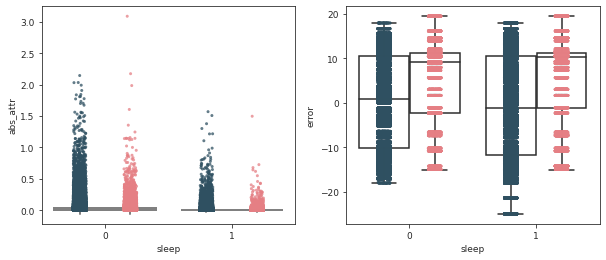

In [114]:
# select only 
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.stripplot(x='sleep', y='abs_attr', data=dt, rasterized=True, hue='ptb_37wks', 
              palette=ptb_cmap, dodge=True, ax=ax[0], s=3, alpha=0.75)
sns.barplot(x='sleep', y='abs_attr', 
                data=dt,
                facecolor='none', edgecolor='gray',
                errwidth=2,
                errcolor='gray',
                linewidth=2,
                hue='ptb_37wks',
                ci='sd',
                dodge=True,
                palette=ptb_cmap,
                zorder=1,
           ax=ax[0])
sns.stripplot(x='sleep', y='error', data=dt, rasterized=True, hue='ptb_37wks', 
              palette=ptb_cmap, dodge=True, ax=ax[1], s=3, alpha=0.75)
sns.boxplot(x='sleep', y='error', data=dt, hue='ptb_37wks', 
            palette=ptb_cmap,
            boxprops={'facecolor':'none'}, showfliers=False, ax=ax[1])
ax[0].legend().set_visible(False)
ax[1].legend().set_visible(False)
if savefigs:
    fig.savefig(os.path.join(pfp, 'stripplot_imp&errVsleepv71.pdf'), bbox_inches='tight', dpi=600, )

### AU-ROC and COEF from LR with SMOTE?

#### wrt to ptb

since just by tod doesn't look good

In [115]:
imp1 = weartabcorr.elasticnet(dt.loc[dt['ptb_37wks']==1, :], 'abs_attr', 'sleep')
imp0 = weartabcorr.elasticnet(dt.loc[dt['ptb_37wks']==0, :], 'abs_attr', 'sleep')
err1 = weartabcorr.elasticnet(dt.loc[dt['ptb_37wks']==1, :], 'error', 'sleep')
err0 = weartabcorr.elasticnet(dt.loc[dt['ptb_37wks']==0, :], 'error', 'sleep')


In [116]:
line_cmap = {
    'PTB+, Importance': '#533E85',
    'PTB-, Importance': '#488FB1',
    'PTB+, Error': '#4FD3C4',
    'PTB-, Error': '#C1F8CF',
}

In [117]:
def plot_auroc_out(a, ax, label, line_cmap, verbose=True):
    ax.plot(a[0], np.mean(a[1], 0), color=line_cmap[label], label=label)
    ax.fill_between(a[0], np.mean(a[1], 0) - np.std(a[1], 0), np.mean(a[1], 0) + np.std(a[1], 0), 
                    color=line_cmap[label], alpha=0.5)
    ax.text(0.6, 0.2, f'AU-ROC={np.mean(a[2]):.2f}', transform=ax.transAxes, color=line_cmap[label]) #  ({np.std(mve[2]):.1f})
    if verbose:
        print(f'AU-ROC={np.mean(a[2]):.2f}')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend()
    return ax

AU-ROC=0.94
AU-ROC=0.94
AU-ROC=0.47
AU-ROC=0.53


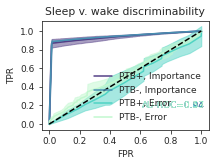

In [118]:

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
plot_auroc_out(imp1, ax, 'PTB+, Importance', line_cmap)
plot_auroc_out(imp0, ax, 'PTB-, Importance', line_cmap)
plot_auroc_out(err1, ax, 'PTB+, Error', line_cmap)
plot_auroc_out(err0, ax, 'PTB-, Error', line_cmap)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_title('Sleep v. wake discriminability')
if savefigs:
    fig.savefig(os.path.join(pfp, 'lineplot_tprVfpr_sleeppred_fromimperr_byptbgrpv71.pdf'), bbox_inches='tight')

# pval table with all these comparisons

heatmap plot of nlog10 pval between comparisons too

### corr plot with RA/IS and imp/err?

In [119]:
sleep_cmap = {0:'#FAD02C', 1:'#333652'}


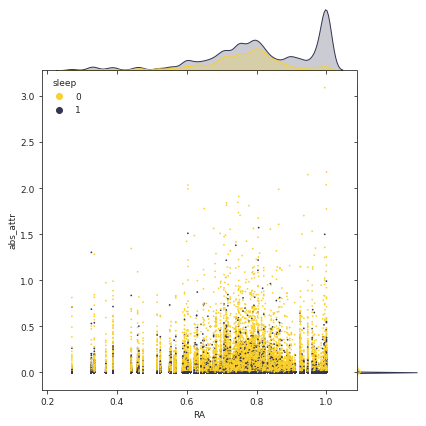

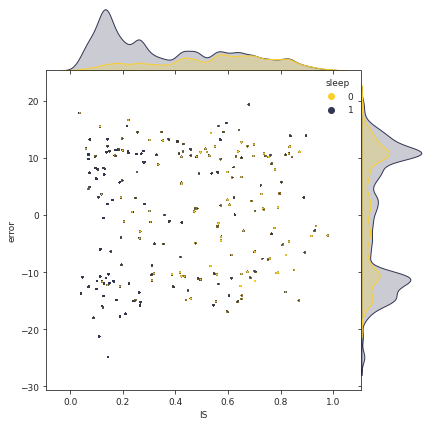

In [121]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 4))
p1 = sns.jointplot(x='RA', y='abs_attr', data=dt, rasterized=True, hue='sleep', palette=sleep_cmap, linewidth=0, s=3, space=0)
# ax[0].set_yscale('log')
if savefigs:
    p1.savefig(os.path.join(pfp, 'joinplot_impVRA_byslpv71.pdf'), bbox_inches='tight', dpi=600)

p2 = sns.jointplot(x='IS', y='error', data=dt, hue='sleep', rasterized=True, linewidth=0, palette=sleep_cmap, s=3, space=0)
# ax[1].set_yscale('log')
if savefigs:
    p2.savefig(os.path.join(pfp, 'joinplot_errorVRA_byslpv71.pdf'), bbox_inches='tight', dpi=600)

### from md_vars/(err grp V t.o.d. grp)

## specifics of imp corr

### ptb and RA


### from md_vars/(err grp V t.o.d. grp)

# dev

#### imp corrs for time-of-day

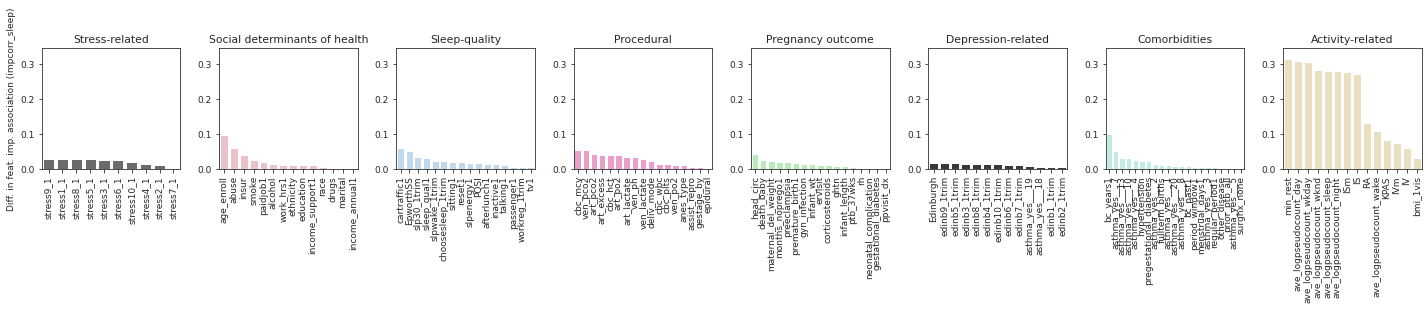

In [123]:
# wrangle df
for k_a in ['impcorr_sleep']:
    dt = results_all[k_a]
    if 'sleep' in k_a:
        dt['diff_slpVwake'] = dt[1] - dt[0]
    dt['cat'] = dt.index.map(md_node_annotation)
    dt = dt.loc[~dt['cat'].isna()]
    dt = dt.reset_index().melt(id_vars=['cat', 'index'])
    dt['value'] = dt['value'].abs()
    dt = dt.sort_values(by=['cat', 'value'], ascending=False)

    # plot
    if 'sleep' in k_a:
        dtt = dt.loc[(dt['variable']=='diff_slpVwake')]
    else:
        dtt = dt.loc[dt['variable']!='all']

    fig = plt.figure(figsize=(20, 4))
    for i, cat in enumerate(dt['cat'].unique()):
        ax = fig.add_subplot(1, 8, i+1)
        sns.barplot(x='index', y='value', data=dtt.loc[(dtt['cat']==cat)], hue='cat', palette=md_node_category_cmap, ax=ax)
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        if i==0:
            ax.set_ylabel(f'Diff. in feat. imp. association ({k_a})')
        else:
            ax.set_ylabel('')
        ax.legend().set_visible(False)
        ax.set_title(cat)
        ax.set_ylim([0, 0.1*np.max(dtt['value'])+np.max(dtt['value'])])
    fig.tight_layout()

### error groups

In [124]:
results_all['impcorr_group'].head()

,all,lt10wks,Higher-than-actual,Lower-than-actual,cat
age_enroll,0.110967,0.059405,0.156845,0.095495,Social determinants of health
marital,0.527418,0.550509,0.547641,0.5143,Social determinants of health
gestage_by,0.678758,0.697185,0.563415,0.654863,Procedural
insur,0.582369,0.719959,0.599211,0.628936,Social determinants of health
ethnicity,0.547969,0.535606,0.555302,NaN,Social determinants of health


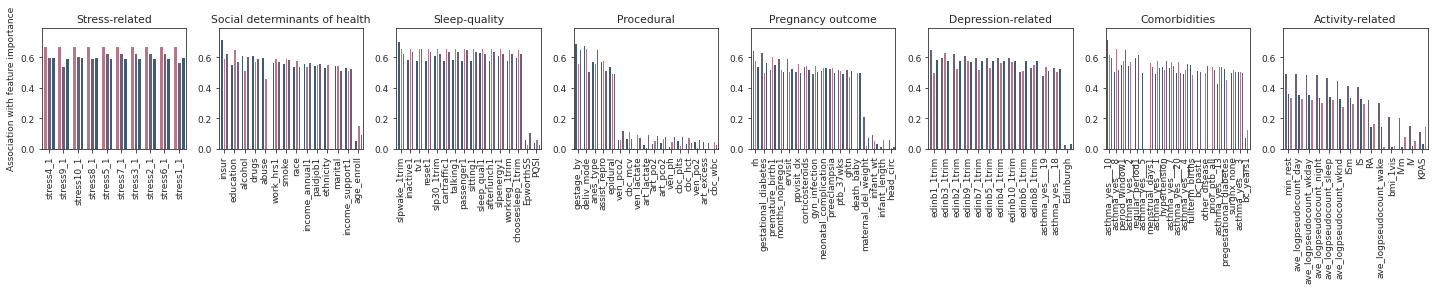

In [125]:
# wrangle df
dt = results_all['impcorr_group']
dt['cat'] = dt.index.map(md_node_annotation)
dt = dt.loc[~dt['cat'].isna()]
dt = dt.reset_index().melt(id_vars=['cat', 'index'])
dt['value'] = dt['value'].abs()
dt = dt.sort_values(by=['cat', 'value'], ascending=False)

# plot
dtt = dt.loc[dt['variable']!='all']
fig = plt.figure(figsize=(20, 4))
for i, cat in enumerate(dt['cat'].unique()):
    ax = fig.add_subplot(1, 8, i+1)
    sns.barplot(x='index', y='value', data=dtt.loc[(dtt['cat']==cat)], hue='variable', palette=grp_cmap, ax=ax)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    if i==0:
        ax.set_ylabel('Association with feature importance')
    else:
        ax.set_ylabel('')
    ax.legend().set_visible(False)
    ax.set_title(cat)
    ax.set_ylim([0, 0.1*np.max(dtt['value'])+np.max(dtt['value'])])
fig.tight_layout()

In [126]:
results_all['errcorr'].head()

,all,lt10wks,Higher-than-actual,Lower-than-actual
age_enroll,0.000775,-0.053258,0.075985,0.078402
marital,0.454053,0.54437,0.532253,0.560797
gestage_by,0.586674,0.616574,0.56384,0.588588
insur,0.757803,0.809038,0.830883,0.62852
ethnicity,0.33223,0.353417,0.674661,0.634519


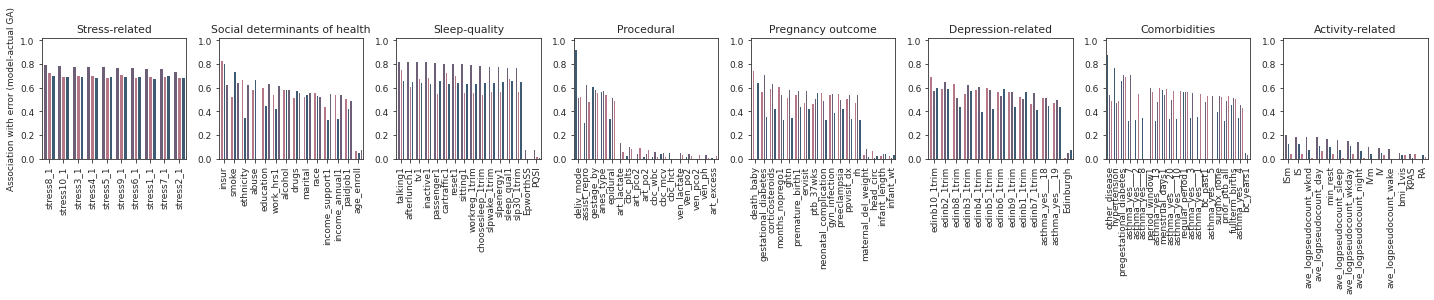

In [127]:
# wrangle df
dt = results_all['errcorr']
dt['cat'] = dt.index.map(md_node_annotation)
dt = dt.loc[~dt['cat'].isna()]
dt = dt.reset_index().melt(id_vars=['cat', 'index'])
dt['value'] = dt['value'].abs()
dt = dt.sort_values(by=['cat', 'value'], ascending=False)

# plot
dtt = dt.loc[dt['variable']!='all']
fig = plt.figure(figsize=(20, 4))
for i, cat in enumerate(dt['cat'].unique()):
    ax = fig.add_subplot(1, 8, i+1)
    sns.barplot(x='index', y='value', data=dtt.loc[(dtt['cat']==cat)], hue='variable', palette=grp_cmap, ax=ax)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    if i==0:
        ax.set_ylabel('Association with error (model-actual GA)')
    else:
        ax.set_ylabel('')
    ax.legend().set_visible(False)
    ax.set_title(cat)
    ax.set_ylim([0, 0.1*np.max(dtt['value'])+np.max(dtt['value'])])
fig.tight_layout()

### plots for all, grouped by md var category

show all first with appropriate color panel, then go into details of interesting ones

In [131]:
errgrpcorr[['all', 'lt10wks', 'Higher-than-actual', 'Lower-than-actual']]

,all,lt10wks,Higher-than-actual,Lower-than-actual,cat
age_enroll,0.000775,-0.053258,0.075985,0.078402,Social determinants of health
marital,0.454053,0.54437,0.532253,0.560797,Social determinants of health
gestage_by,0.586674,0.616574,0.56384,0.588588,Procedural
insur,0.757803,0.809038,0.830883,0.62852,Social determinants of health
ethnicity,0.33223,0.353417,0.674661,0.634519,Social determinants of health
...,...,...,...,...,...
KPAS,0.055567,-0.009086,0.046036,0.043583,Activity-related
EpworthSS,0.02111,-0.001351,0.001013,0.082928,Sleep-quality
Edinburgh,0.084003,0.083906,-0.013732,0.056897,Depression-related
GA,-0.841042,-0.784031,-0.137108,-0.152822,NaN


In [132]:
# add category labels
from wearables.scripts.aesthetics import md_node_annotation, md_node_category_cmap

md_node_annotation['GA'] = 'Pregnancy outcome'
md_node_annotation['yhat'] = 'Pregnancy outcome'
df = errgrpcorr[['all', 'lt10wks', 'Higher-than-actual', 'Lower-than-actual']].abs()
df['cat'] = [md_node_annotation[i] for i in errgrpcorr.index]


In [133]:
color_groups = 'cat'
ranking_col = 'all'


In [134]:
grp_cmap = {
    'all': '#F67280',
    'Higher-than-actual': '#C06C84',
    'Lower-than-actual': '#6C5B7B',
    'lt10wks': '#355C7D',
}

In [135]:
savefigs = True

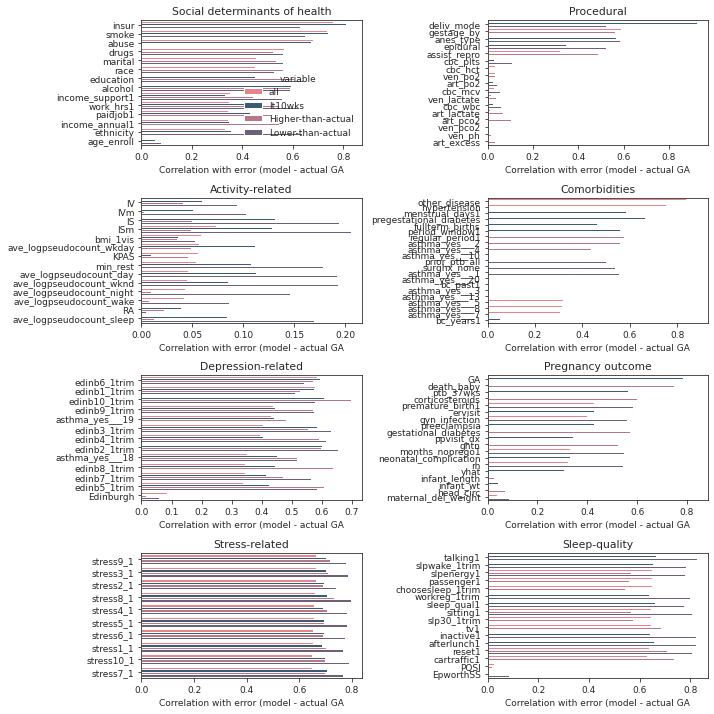

In [136]:
fig = plt.figure(figsize=(10, 10))
for i, c in enumerate(df[color_groups].unique()):
    ax = fig.add_subplot(4, 2, i+1)
    dt = df.loc[df[color_groups]==c, :].sort_values(by=ranking_col, ascending=False)
    dt = dt.reset_index().melt(id_vars=['index', color_groups])
    sns.barplot(x='value', y='index', hue='variable', data=dt, ax=ax, palette=grp_cmap)
    if i!=0:
        ax.legend().set_visible(False)
    ax.set_xlabel('Correlation with error (model - actual GA')
    ax.set_ylabel('')
    ax.set_title(f"{c}")
fig.tight_layout()
if savefigs:
    fig.savefig(os.path.join(pfp, 'barplots_groupedVarsVerrcorrv71.pdf'), bbox_inches='tight')

In [137]:
from scipy.stats import spearmanr 
spearmanr(md['PQSI'], md['error'])

SpearmanrResult(correlation=0.025316184042788244, pvalue=0.22437527017947037)

#### stats to manually draw

sleep yes/no in lt and gt grp

### method

z-test (https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html) and mwu to make point that this is more important... talk about the details in the results and write it

In [138]:
from scipy.stats import ttest_ind, mannwhitneyu

In [146]:
a = res_lt4wk.loc[res_lt4wk['sleep']==1, 'abs_attr']
b = res_lt4wk.loc[res_lt4wk['sleep']==0, 'abs_attr']
ttest_ind(a, b, equal_var=True)

Ttest_indResult(statistic=-409.4257022374753, pvalue=0.0)

<AxesSubplot:xlabel='abs_attr', ylabel='Count'>

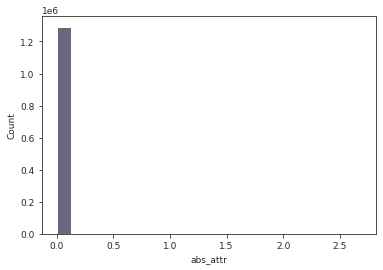

In [149]:
sns.histplot(res_lt4wk.loc[(res_lt4wk['sleep']==1), 'abs_attr'], color=sleep_cmap[1])
# sns.distplot(res_lt2wk.loc[res_lt2wk['sleep']==0, 'abs_attr'], color=sleep_cmap[0])

# plot single examples

In [111]:
savefigs=True

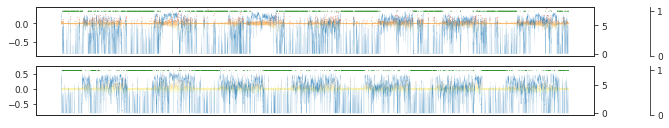

In [115]:
sleep = trainer.data.data['data'][uid_ptb]['sleep'][:-1]
sleep.replace(0, np.nan, inplace=True)
fig, ax = plt.subplots(2, 1, figsize=(10, 2)) 
ax[0].scatter(np.arange(x.shape[-1]), attr_ptb[0, 0, :].detach(), c=attr_ptb[0, 0, :].detach(), cmap='RdYlBu_r', s=0.5, rasterized=True, edgecolor='none')
par2 = ax[0].twinx()
par2.plot(np.arange(x.shape[-1]), x[0, 0, :].detach(), linewidth=0.1, alpha=0.75, rasterized=True)
# par2.set_ylabel('Activity (log pseudocounts)')
par3 = ax[0].twinx()
par3.set_ylim(0, 1.1)
par3.scatter(np.arange(x.shape[-1]), sleep, linewidth=0.1, color='green', s=0.1, rasterized=True, edgecolor='none')
par3.spines.right.set_position(("axes", 1.1))
ax[0].set_xticks([])

sleep_noptb = trainer.data.data['data'][uid_noptb]['sleep'][:-1]
sleep_noptb.replace(0, np.nan, inplace=True)
ax[1].scatter(np.arange(x.shape[-1]), attr_noptb[0, 0, :].detach(), c=attr_noptb[0, 0, :].detach(), cmap='RdYlBu_r', s=0.5, rasterized=True, edgecolor='none')
par2 = ax[1].twinx()
par2.plot(np.arange(x.shape[-1]), x_noptb[0, 0, :].detach(), linewidth=0.1, alpha=0.75, rasterized=True)
# par2.set_ylabel('Activity (log pseudocounts)')
par3 = ax[1].twinx()
par3.set_ylim(0, 1.1)
par3.scatter(np.arange(x.shape[-1]), sleep_noptb, linewidth=0.1, color='green', s=0.1, rasterized=True, edgecolor='none')
par3.spines.right.set_position(("axes", 1.1))
ax[1].set_xticks([])

if savefigs:
    fig.savefig('/home/ngrav/project/wearables/results/ptbVnoptb_pathexpattr.png', bbox_inches='tight', dpi=600)

In [132]:
df_sleep = pd.DataFrame({'sleep': sleep.replace(np.nan, 0).to_list(), 'importance': attr_ptb[0, 0, :].detach().numpy(), 'md':['ptb']*sleep.shape[0]})
dt = pd.DataFrame({'sleep': sleep_noptb.replace(np.nan, 0).to_list(), 'importance': attr_noptb[0, 0, :].detach().numpy(), 'md':['noptb']*sleep_noptb.shape[0]})
df_sleep = df_sleep.append(dt)
del dt

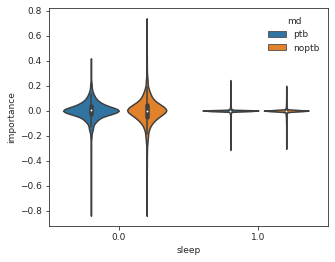

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.violinplot(x='sleep', y='importance', hue='md', data=df_sleep, ax=ax)
# sns.swarmplot(x='sleep', y='importance', hue='md', data=df_sleep, ax=ax)
if savefigs:
    fig.savefig('/home/ngrav/project/wearables/results/violin_ptbVnoptb_bysleep_pathexpattr.png', bbox_inches='tight', dpi=600)

# correlations with error

show corr net, only significant ones can retain edge

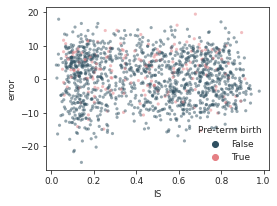

In [150]:
ptb_cmap = {False: '#2F5061', True: '#E57F84'}
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x='IS', y='error', data=md.loc[md['split']=='train'], hue='Pre-term birth',
                palette=ptb_cmap, linewidth=0, s=10, alpha=0.5, rasterized=True, ax=ax)
fig.savefig(os.path.join(pfp, 'scatter_errorVIS_trainv71.pdf'), bbox_inches='tight')

In [151]:
a = md.loc[md['split']=='train', 'IS']
b = md.loc[md['split']=='train', 'error']

spearmanr(a, b)

SpearmanrResult(correlation=-0.04973261121323243, pvalue=0.06181504616915923)

## mask or stratify by feature importance

In [157]:
a = md.loc[:, 'IS']
b = md.loc[:, 'error']

spearmanr(a, b)

SpearmanrResult(correlation=-0.07574660001645252, pvalue=0.0002727618825033861)

In [158]:
0.0002727618825033861

0.0002727618825033861

In [159]:
'{:.2e}'.format(0.0002727618825033861)

'2.73e-04'